In [ ]:
# This is the start of the notebook

## Execution of spelfig over a MAGPI spectrum

In this notebook we are going to execute my code spelfig over a magpi spectrum. This is a single spectrum integrated from the central brightest pixel of the IFS field of the target to a one effective radius (R50). Our goals:

* Achieve a correct execution.
* Measure effectively the time of execution and if possible try to minimize it
* Create a function to iterate fits between different models
* Translate to a script the process in this notebook to generalize it




We locate ourselves in the directory in which the code and the spectra files are. The 2 next cell is a bash command (must not contain python syntax)

In [3]:
!pip install emcee

In [4]:
# We begin the procedure. We have to install emcee in the first place:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

# Import Spelfig packages:
import spl_fitters as spf
# import spl_setup as sps
import sps_setupv2 as sps

In [5]:
# Function to properly extract the MAGPI spectra:
def open_magpi_ppxf(file):
    smooth_sigma = 0.4 # To smooth the data with a gaussian kernel.
    flyspec = fits.open(file)
    flyspec = flyspec[1].data

    wave = flyspec['wavelength']
    gas_flux = flyspec['lines flux']
    err_flux = flyspec['flux error']

    spec = np.array([wave, gas_flux, err_flux]).T
    # spec = gaussian_filter1d(spec, smooth_sigma, axis=0)

    return spec

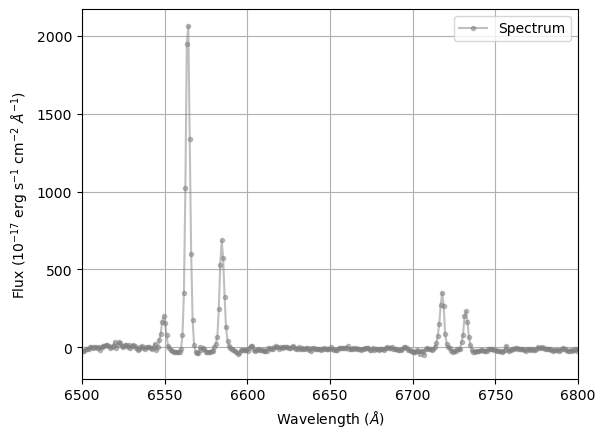

In [6]:
# We open the spectrum and visualize it:
file = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/magpi2304104201_aperture_1.25R50_ppxf.fits'
spec0 = open_magpi_ppxf(file)

# Define the spectrum
spectrum = spec0[:, 1]

plt.figure()
plt.plot(spec0[:, 0], spec0[:, 1], color='grey', marker='.', linestyle='-', label='Spectrum',
		 alpha=0.5)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Flux ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# plt.xlim(4800, 5010)
plt.xlim(6500, 6800)
# plt.ylim(-500, 500)
plt.grid('False')
plt.legend()
plt.show()


In [7]:
# We constrain the spectral range to be fitted:
specrange = (4800, 6800)

In [8]:
# LINES DICTIONARIES:
# For reminding:
# Broad Line Region Lines (FOR AGNs):
# 'He-II,1', 'He-II,2', 'H-ζ', 'H-ε', 'H-δ', 'H-γ', 'H-β', 'He-I', 'H-α'
# Narrow Line Region:
# 	'O-III,1', 'O-III,2', 'N-II,1', 'N-II,2', 'S-II,1', 'S-II,2'

emission_line_models = {
	'He-II,1': {'wavelength':[3202.15], 'components': ['Gaussian', 'Gaussian']},
	'He-II,2': {'wavelength':[4685.74], 'components': ['Gaussian', 'Gaussian']},
	'Ne-V,1':  {'wavelength':[3345.81], 'components': ['Gaussian']},
	'Ne-V,2':  {'wavelength':[3425.81], 'components': ['Gaussian']},
	'O-II,1':  {'wavelength':[3726.03], 'components': ['Gaussian']},
	'O-II,2':  {'wavelength':[3728.73], 'components': ['Gaussian']},
	'Ne-III,1': {'wavelength':[3868.69], 'components': ['Gaussian']},
	'Ne-III,2': {'wavelength':[3967.40], 'components': ['Gaussian']},
	'H-ζ':    {'wavelength':[3889.05], 'components': ['Gaussian', 'Gaussian']},
	'H-ε':    {'wavelength':[3970.07], 'components': ['Gaussian', 'Gaussian']},
	'H-δ':    {'wavelength':[4101.73], 'components': ['Gaussian', 'Gaussian']},
	'H-γ':    {'wavelength':[4340.46], 'components': ['Gaussian', 'Gaussian']},
	'O-III,0':  {'wavelength':[4363.15], 'components': ['Gaussian']},
	'O-III,1':  {'wavelength':[4958.83], 'components': ['Gaussian', 'Lorentzian']},
	'O-III,2':  {'wavelength':[5006.77], 'components': ['Gaussian', 'Lorentzian']},
	'Ar-IV,1':  {'wavelength':[4711.30], 'components': ['Gaussian']},
	'Ar-IV,2':  {'wavelength':[4740.10], 'components': ['Gaussian']},
	'H-β':     {'wavelength':[4861.32], 'components': ['Gaussian', 'Gaussian']},
	'N-I,1':    {'wavelength':[5197.90], 'components': ['Gaussian']},
	'N-I,2':    {'wavelength':[5200.39], 'components': ['Gaussian']},
	'He-I':   {'wavelength':[5875.60], 'components': ['Gaussian']},
	'O-I,1':   {'wavelength':[6300.20], 'components': ['Gaussian']},
	'O-I,2':   {'wavelength':[6363.67], 'components': ['Gaussian']},
	'N-II,1':   {'wavelength':[6547.96], 'components': ['Gaussian']},
	'N-II,2':   {'wavelength':[6583.34], 'components': ['Gaussian']},
	'H-α':     {'wavelength':[6562.80], 'components': ['Gaussian', 'Gaussian']},
	'S-II,1':  {'wavelength': [6716.31], 'components': ['Gaussian', 'Lorentzian']},
	'S-II,2':   {'wavelength':[6730.68], 'components': ['Gaussian', 'Lorentzian']},
	'Ar-III': {'wavelength':[7135.67], 'components': ['Gaussian']},
	}


Create the first estimations

In [9]:
# spec0[(spec0[:,0]>=specrange[0]) & (spec0[:,0]<=specrange[1])]

In [10]:
# ## Lets create the first array with

# ## Spectral index for the continuum:
# gamma0 = -0.01

# ## Observed data stored in variables:

# df0 = sps.init_setup(spec0, emission_line_models, np.array(specrange), gamma0);

In [11]:
## Initial assumptions for the continuum
initial_conditions = {
    "powerlaw function": {"gamma": -0.01}
}

## Spectral index for the continuum:
gamma0 = -0.01

## Observed data stored in variables:

try:
    df0 = sps.init_setup(spec0, emission_line_models, specrange, gamma0);
except RuntimeWarning:
    print("Error occurred during setup. Skipping...")
    df0 = np.empty(0)

df0

This is 3 sigma: 53.51121439230768
Appending continuum
[-2.27277889e+01  5.64477738e+03  1.74500803e+00]


/Users/aksitadeo/PycharmProjects/spelfig_aksita/spl_models.py:25: RuntimeWarning: invalid value encountered in power
  return a*(x/b)**(-c)


Line Name       Model  Component  \
0     O-III,2    Gaussian          1   
1     O-III,2  Lorentzian          2   
2         H-β    Gaussian          1   
3         H-β    Gaussian          2   
4      N-II,1    Gaussian          1   
5      N-II,2    Gaussian          1   
6         H-α    Gaussian          1   
7         H-α    Gaussian          2   
8      S-II,1    Gaussian          1   
9      S-II,1  Lorentzian          2   
10     S-II,2    Gaussian          1   
11     S-II,2  Lorentzian          2   
12  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188178510806, 87.77592864906612, 1.53713...   
1   [5008.188178510806, 87.77592864906612, 1.70622...   
2   [4862.393123281022, 241.7418739209638, 1.13597...   
3   [4862.393123281022, 241.7418739209638, 1.13597...   
4   [6549.389130411604, 197.53728692170915, 1.5120...   
5   [6584.504061008252, 687.0331027865863, 1.38558...   
6   [6564.290036114264, 1032.5648944107559, 1.2919...   
7   [6564.290036114264, 1032.5648944107559, 1.2919...   
8   [6717.870097392305, 174.69643311051422, 1.3489...   
9   [6717.870097392305, 174.69643311051422, 1.4973...   
10  [6732.254290192208, 114.95951833423564, 1.3194...   
11  [6732.254290192208, 114.95951833423564, 1.4645...   
12  [-22.727788925828136, 5644.777383527146, 1.745...   

                                           Max Limits  \
0   [5011.262458217838, 175.55185729813223, 2.3057...   
1   [5011.262458217838, 175.55185729813223, 2.5593...   
2   [4864.665067576926, 483.4837478419276, 1.70395...   
3   [4864.665067576926, 483.4837478419276, 1.70395...   
4   [6552.413236668445, 197.53728692170915, 2.2680...   
5   [6587.275228852098, 687.0331027865863, 2.07837...   
6   [6566.8738459964825, 2065.1297888215117, 1.937...   
7   [6566.8738459964825, 2065.1297888215117, 1.937...   
8   [6720.567985667452, 349.39286622102844, 2.0234...   
9   [6720.567985667452, 349.39286622102844, 2.2459...   
10  [6734.893203037415, 229.91903666847128, 1.9791...   
11  [6734.893203037415, 229.91903666847128, 2.1968...   
12                                    [inf, inf, inf]   

                         Min Limits  
0     [5005.113898803775, 0.0, 2.0]  
1    [5005.113898803775, 0.0, 2.22]  
2     [4860.121178985118, 0.0, 2.0]  
3     [4860.121178985118, 0.0, 2.0]  
4     [6546.365024154763, 0.0, 2.0]  
5     [6581.732893164407, 0.0, 2.0]  
6     [6561.706226232045, 0.0, 2.0]  
7     [6561.706226232045, 0.0, 2.0]  
8     [6715.172209117158, 0.0, 2.0]  
9    [6715.172209117158, 0.0, 2.22]  
10   [6729.6153773470005, 0.0, 2.0]  
11  [6729.6153773470005, 0.0, 2.22]  
12                  [-inf, 0, -inf]

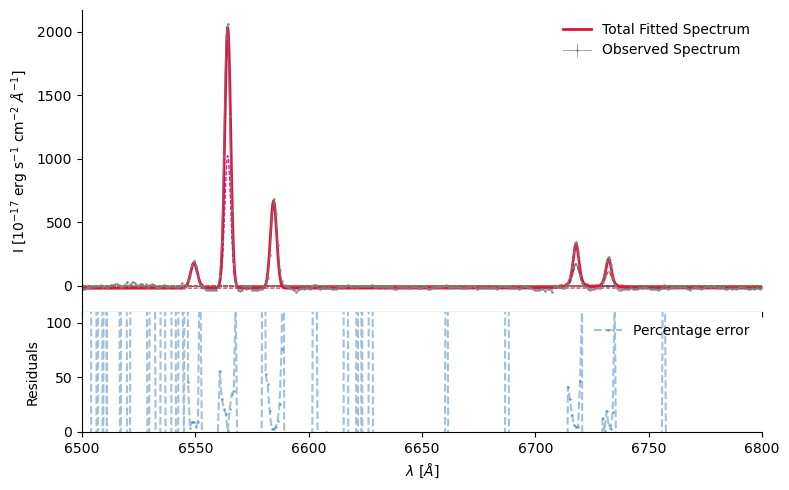

In [12]:
# Lets visualize the initial estimations:
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], df0, x_zoom=(6500, 6800))

In [13]:
# Time to run the emcee fits:
fit0 = spf.run_mcmc_chains(df0, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=5000)
fit0

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


ndim inside sampler 39


100%|██████████| 5000/5000 [00:02<00:00, 2139.92it/s]


Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-β    Gaussian          1   
3         H-β    Gaussian          2   
4      N-II,1    Gaussian          1   
5      N-II,2    Gaussian          1   
6     O-III,2    Gaussian          1   
7     O-III,2  Lorentzian          2   
8      S-II,1    Gaussian          1   
9      S-II,1  Lorentzian          2   
10     S-II,2    Gaussian          1   
11     S-II,2  Lorentzian          2   
12  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188697622197, 87.7756788189297, 1.536403...   
1   [5008.188566168993, 87.77604887551263, 1.70536...   
2   [4862.393570587387, 241.7442639926176, 1.13568...   
3   [4862.393514419152, 241.7414250710634, 1.13635...   
4   [6549.390225763383, 197.53658716237013, 1.5115...   
5   [6584.50442939144, 687.0324829673391, 1.385314...   
6   [6564.289162656907, 1032.5628825558963, 1.2912...   
7   [6564.290733028676, 1032.564402868708, 1.29060...   
8   [6717.870001077805, 174.69720204631037, 1.3492...   
9   [6717.869199561034, 174.69654717379674, 1.4964...   
10  [6732.253659601964, 114.95918866310784, 1.3176...   
11  [6732.253987354969, 114.95965686482477, 1.4650...   
12  [-22.72818156790199, 5644.776673141739, 1.7423...   

                                     Parameter Errors  
0   [0.0009730525720781418, 0.0009627624627973492,...  
1   [0.0009578539737319422, 0.0009770073227212412,...  
2   [0.0010072410965851957, 0.0009187201856227709,...  
3   [0.0010027232479255046, 0.0010872297049025266,...  
4   [0.000989346687128153, 0.000832434524441371, 0...  
5   [0.0009830609586764134, 0.0009769084216132828,...  
6   [0.0010771671396784342, 0.000910167547511281, ...  
7   [0.0008395411675932466, 0.00107072387140184, 0...  
8   [0.0010481568353400608, 0.000917601892852634, ...  
9   [0.0009646151875473794, 0.001076144616100906, ...  
10  [0.0010314245136944563, 0.0010773154058182726,...  
11  [0.0011036782209084546, 0.0010702365667815425,...  
12  [0.0010164651638296335, 0.0010243577679067656,...

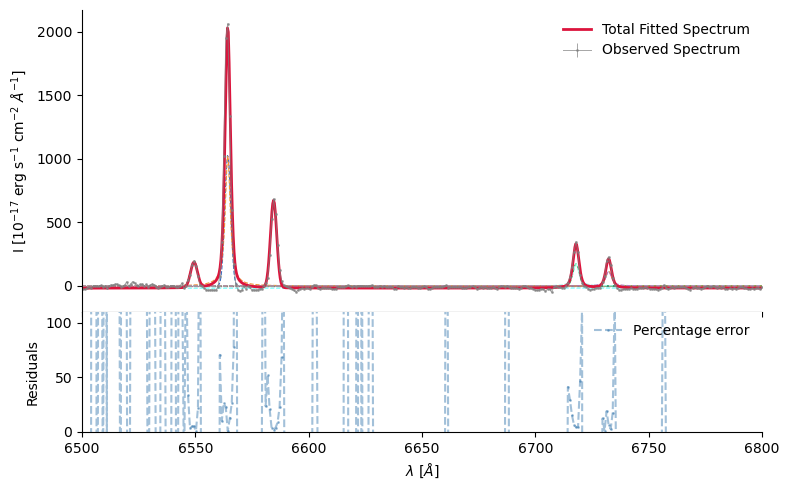

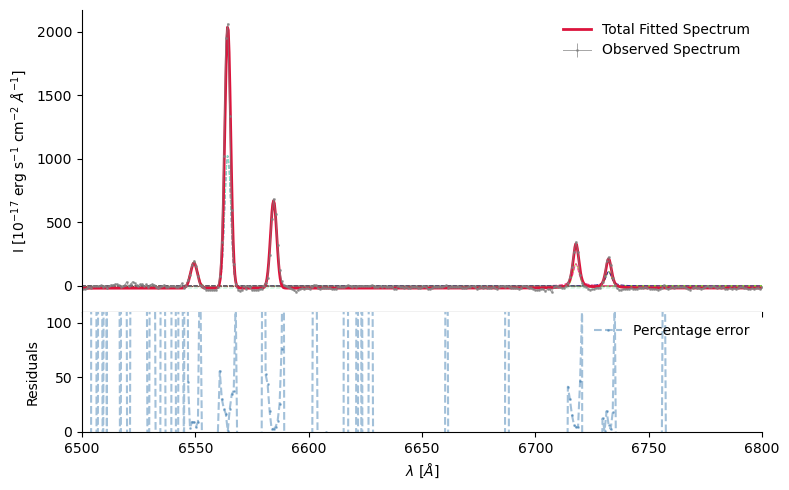

In [14]:
# Plot the initial estimation against the converged values
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], df0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))

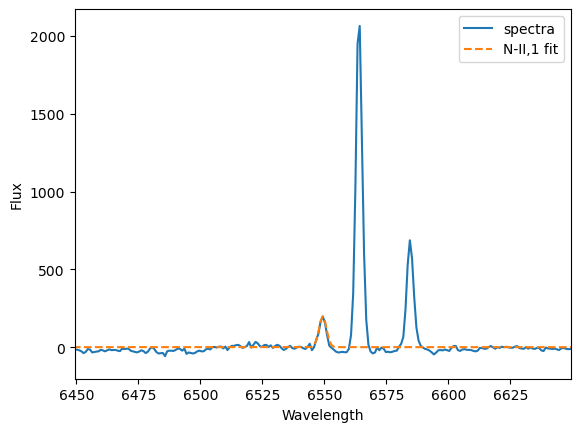

In [15]:
'''
Let's have a look at an individual fit of one of the emission lines, assuming it's Gaussian:
Taking a Gaussian with the form  a * np.exp(-0.5*((x - b / c)**2))
'''

# Define the emission line
Emission_line = 'N-II,1'
params = fit0[fit0['Line Name'] == Emission_line]

# Generate x-axis values
x = spec0[:, 0]
gauss_comp = []

for index, row in params.iterrows():

  # Define the Gaussian
  b, a, c  = row["Parameters"] # Extract parameters from the row
  # Calculate Gaussian & Append
  gauss = a * np.exp(-(x-b)**2/(2*c**2))
  gauss_comp.append(gauss)

gauss_total = np.sum(gauss_comp, axis=0)

# Normalise spectra (optional, depending on data)
# spec0_norm = spec0[:, 1] / np.max(spec0[:, 1])

# Zoom into the plot
lowerlim = b - 100
upperlim = b + 100

# Plot the Gaussian distribution and normalised spectra
plt.plot(x, spec0[:, 1], label='spectra')
plt.plot(x, gauss_total, label=Emission_line + ' fit', ls='dashed')
plt.xlim(lowerlim, upperlim)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

## Next step: elevating the number of components for a given list of lines.
This should be a good goal to hit for the next week. Let´s dive into it and discuss any progress on Friday. We have to:
* Create a function that takes as inputs:
 * A given dataframe with same structure as the input and output one from the run_mcmc_chains method.
 * A list of a subgroup of lines with components to ADD the current model (see cell below)
 * Based on that: take the parameters from the previous component(s) as guesses for the next ones, update correctly the dataframe, and run the run_mcmc_chains method again.



---

*Refinements*

 Add extra method that identifies when adding more components whether the centroid is blue or red shifted compared to the previous profile (calculate which side the mean residuals are shifted towards) and update further guesses

####A function to update components without recalculating minimum and maximum limits:



In [16]:
def update_components(dfparams, dfog, additional_components_dict, num):
    '''
    This function takes a dataframe of a given emission line spectral model and
    updates it with additional components, in consistency with the lines specified
    in the additional_components_dict.

    dfparams: output of earlier mcmc runs
    dfog: original dataframe of spectra
    additional_components_dict: a dictionary of the components to be added
    num: number of iterations to run the mcmc chains
    '''

    # Create a copy of the input dataframe to avoid modifying the original
    updated_df = dfparams.copy()
    df_zero = dfog.copy()

    # Sort by emission lines to add correct limits
    updated_df.sort_values(by=['Line Name']).reset_index(drop=True)
    df_zero.sort_values(by=['Line Name']).reset_index(drop=True)

    # Remove error column
    updated_df = updated_df.drop(['Parameter Errors'], axis=1)

    # Borrow Min and Max limits
    updated_df['Max Limits'] = df_zero['Max Limits']
    updated_df['Min Limits'] = df_zero['Min Limits']

    # Group the emission lines in the dataframe:
    # grouped = updated_df.groupby('Line Name')
    # updated_df = grouped.copy()
    # grouped

    # Iterate over the additional components dictionary

    for line, components in add_components_1.items():
      if (line in updated_df['Line Name'].values):
        print("Adding a {} component for {}".format(components[0], line))

        # Find the last instance of the element
        last_index = updated_df[updated_df['Line Name'] == line].index[-1]
        # Add a new component
        new_component_number = updated_df.loc[last_index, 'Component'] + 1

        # Copy the same parameters, updating the initial amplitude guess
        new_parameters = updated_df.loc[last_index, 'Parameters']
        new_parameters = [new_parameters[0], new_parameters[1]/2, new_parameters[2]]

        # Copy the limits from original dataframe
        new_parameter_max = updated_df.loc[last_index, 'Max Limits']
        new_parameter_max = [new_parameter_max[0], new_parameter_max[1]/2, new_parameter_max[2]]

        new_parameter_min = updated_df.loc[last_index, 'Min Limits']
        new_parameter_min = [new_parameter_min[0], new_parameter_min[1]/2, new_parameter_min[2]]

        new_row = {'Line Name': line, 'Component': new_component_number, 'Model': components[0], 'Parameters': new_parameters, 'Max Limits': new_parameter_max, 'Min Limits': new_parameter_min}
        updated_df = pd.concat([updated_df[:last_index + 1], pd.DataFrame([new_row]), updated_df[last_index + 1:]], ignore_index=True)

      else:
        print(f"{line} not found in the Spectrum.")

    # Run MCMC
    final_updated_df = spf.run_mcmc_chains(updated_df, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=num)


    # Return the updated dataframe
    return final_updated_df, updated_df


In [17]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

newdf, newdf0 = update_components(fit0, df0, add_components_1, num=5000)
display(newdf)

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 54


100%|██████████| 5000/5000 [00:02<00:00, 1708.01it/s]


Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-β    Gaussian          1   
4         H-β    Gaussian          2   
5         H-β    Gaussian          3   
6      N-II,1    Gaussian          1   
7      N-II,2    Gaussian          1   
8     O-III,2    Gaussian          1   
9     O-III,2  Lorentzian          2   
10    O-III,2    Gaussian          3   
11     S-II,1    Gaussian          1   
12     S-II,1  Lorentzian          2   
13     S-II,1    Gaussian          3   
14     S-II,2    Gaussian          1   
15     S-II,2  Lorentzian          2   
16     S-II,2  Lorentzian          3   
17  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188490108699, 87.77702721331708, 1.53593...   
1   [5008.188497007809, 87.77662869495678, 1.70558...   
2   [5008.188474609491, 43.886963172623474, 1.7047...   
3   [4862.394065226894, 241.74476731003753, 1.1370...   
4   [4862.394510526104, 241.74155725255744, 1.1376...   
5   [4862.394458982321, 120.8719273889066, 1.13604...   
6   [6549.390165668986, 197.5365075326897, 1.51116...   
7   [6584.503497742335, 687.0341317706749, 1.38620...   
8   [6564.290527769679, 1032.5637230890782, 1.2899...   
9   [6564.291670847465, 1032.5648744746477, 1.2897...   
10  [6564.289737598208, 516.2842167330762, 1.28972...   
11  [6717.870608313244, 174.69702422262273, 1.3488...   
12  [6717.868661163377, 174.69814092828625, 1.4957...   
13  [6717.869194294603, 87.34851430748697, 1.49613...   
14  [6732.2540882001385, 114.95880842285743, 1.318...   
15  [6732.2545579465095, 114.95915678657781, 1.465...   
16  [6732.253810792962, 57.47814877872118, 1.46538...   
17  [-22.727790455691114, 5644.776220273818, 1.740...   

                                     Parameter Errors  
0   [0.001215172845982314, 0.0009886963525209966, ...  
1   [0.0009024028843138404, 0.0010201438460105555,...  
2   [0.0009577297972768837, 0.0010192354235613774,...  
3   [0.0011858213443855846, 0.0009418874555784066,...  
4   [0.0010333428599280622, 0.001089270377214655, ...  
5   [0.0009627414142724997, 0.0009648784681646226,...  
6   [0.0008596687788324558, 0.0010349472454834541,...  
7   [0.0010363518714222005, 0.0010225997129424446,...  
8   [0.0009374603161593339, 0.0010851731755179312,...  
9   [0.000928133609604306, 0.0009535953887059254, ...  
10  [0.0009790734839501755, 0.00097819230384648, 0...  
11  [0.0009614903161086354, 0.0009421910103288695,...  
12  [0.001006317507410102, 0.0009606835510477011, ...  
13  [0.0009279436245341858, 0.0011450443718774895,...  
14  [0.0009815058885276143, 0.0009645920768654839,...  
15  [0.0011028919615064306, 0.000990814526989277, ...  
16  [0.0009884609068129273, 0.0009814539855236783,...  
17  [0.0009514179695459504, 0.0008615362796922595,...

In [18]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

secnewdf, secnewdf0 = update_components(newdf, newdf0, add_components_1, num=5000)
display(secnewdf)

O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 69


/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:03<00:00, 1324.38it/s]


Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-α    Gaussian          4   
4         H-β    Gaussian          1   
5         H-β    Gaussian          2   
6         H-β    Gaussian          3   
7         H-β    Gaussian          4   
8      N-II,1    Gaussian          1   
9      N-II,2    Gaussian          1   
10    O-III,2    Gaussian          1   
11    O-III,2  Lorentzian          2   
12    O-III,2    Gaussian          3   
13    O-III,2    Gaussian          4   
14     S-II,1    Gaussian          1   
15     S-II,1  Lorentzian          2   
16     S-II,1    Gaussian          3   
17     S-II,1    Gaussian          4   
18     S-II,2    Gaussian          1   
19     S-II,2  Lorentzian          2   
20     S-II,2  Lorentzian          3   
21     S-II,2  Lorentzian          4   
22  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.191050139189, 87.77777693409797, 1.53681...   
1   [5008.187245204071, 87.77521745766018, 1.70653...   
2   [5008.189463608896, 43.88630465224003, 1.70414...   
3   [5008.188059101589, 21.9440786628751, 1.705654...   
4   [4862.394135370417, 241.74552090659034, 1.1371...   
5   [4862.394798579469, 241.74144586327674, 1.1376...   
6   [4862.393872117942, 120.86996954081287, 1.1349...   
7   [4862.396079078242, 60.43527927574293, 1.13866...   
8   [6549.391247902814, 197.53553946915238, 1.5120...   
9   [6584.505333904625, 687.0333366088481, 1.38438...   
10  [6564.289821761558, 1032.5648451829336, 1.2890...   
11  [6564.291313840753, 1032.565074414556, 1.28997...   
12  [6564.289665741476, 516.2854824946351, 1.28940...   
13  [6564.290663286964, 258.14405010683276, 1.2896...   
14  [6717.870109509502, 174.69806959406236, 1.3480...   
15  [6717.868532666124, 174.69781893130695, 1.4966...   
16  [6717.867627695801, 87.34918240014966, 1.49617...   
17  [6717.868393072832, 43.67442237538257, 1.49554...   
18  [6732.253869518168, 114.96030106247426, 1.3177...   
19  [6732.255675344533, 114.9590131793091, 1.46581...   
20  [6732.253370389358, 57.47717355139373, 1.46617...   
21  [6732.251962209363, 28.738939108154543, 1.4666...   
22  [-22.72717070683314, 5644.77549106681, 1.74070...   

                                     Parameter Errors  
0   [0.0009262508664189749, 0.0009433956866532621,...  
1   [0.0009757514241267282, 0.0010644093247697871,...  
2   [0.0009593410476001426, 0.0009678016864592051,...  
3   [0.0010071735864158689, 0.0010274476170248192,...  
4   [0.0009370858996655536, 0.0009315435997387476,...  
5   [0.0009561819605556854, 0.0011126432375573039,...  
6   [0.001111128083474214, 0.0009082894904050753, ...  
7   [0.0009109616410805428, 0.0009754349020544687,...  
8   [0.0010706858603523714, 0.0009636951637054309,...  
9   [0.001029302691025898, 0.0009941898342201378, ...  
10  [0.0009994823705709473, 0.0010045273034909883,...  
11  [0.0009790414441691046, 0.0009735802322289302,...  
12  [0.0009379230059162029, 0.0009095438720089653,...  
13  [0.0010176667740701675, 0.0009982792012458422,...  
14  [0.0010278882150525958, 0.001021809995020171, ...  
15  [0.0009781989638551402, 0.0010069504578713885,...  
16  [0.0009443497371823352, 0.0011100104783610281,...  
17  [0.0010363128988420548, 0.0009014207467333129,...  
18  [0.00099247028163786, 0.0010122624261296339, 0...  
19  [0.0010621291129096443, 0.0011124681657340763,...  
20  [0.0009953340531903923, 0.0009374419036798205,...  
21  [0.000989537042403224, 0.0009423646850852007, ...  
22  [0.0009429325689601286, 0.0010342429716106143,...

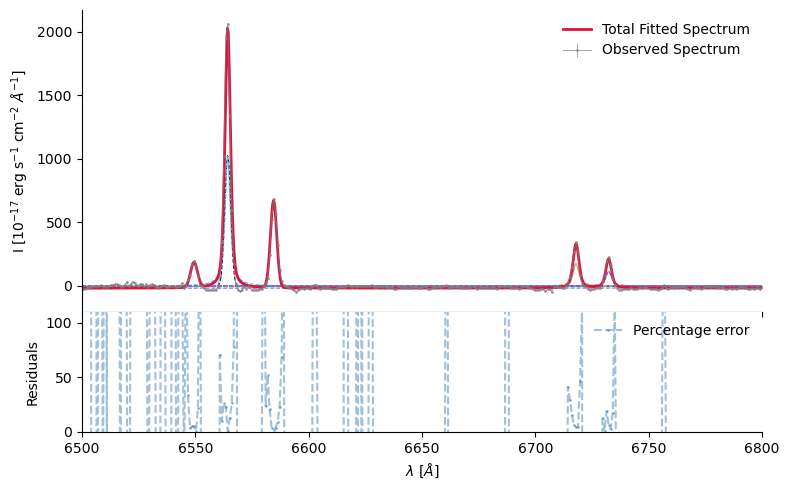

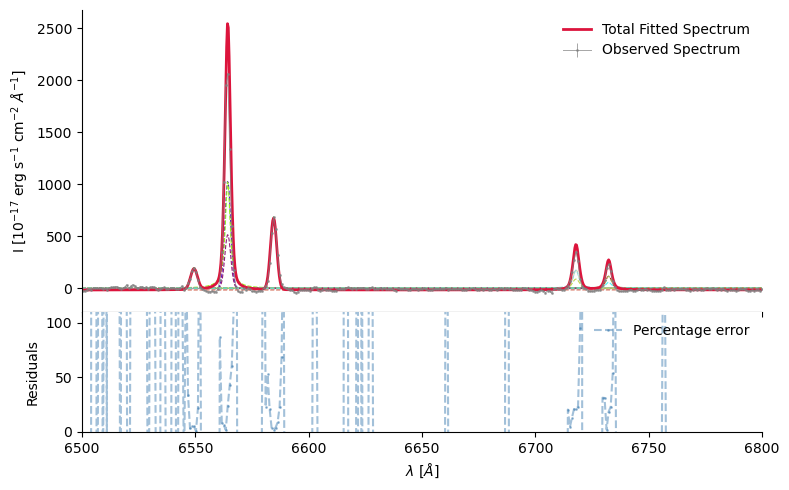

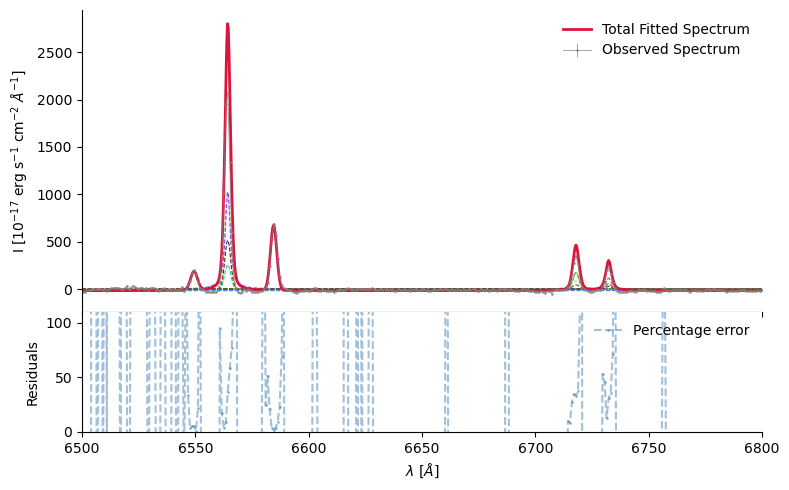

In [19]:
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot2 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], secnewdf, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))

####A function to update components while recalculating minimum and maximum limits:


In [20]:
def minmaxlim(df):
  min_limits = []
  max_limits = []

  for index, row in df.iterrows():

      # Definitions
      # standard deviation
      sigma = row['Parameters'][2]
      minsig = 2.0
      maxsig = 1.5 * sigma
      # wavelength
      line_wavelength = row['Parameters'][0]
      min_line = line_wavelength - 2 * sigma
      max_line = line_wavelength + 2 * sigma
      # amplitude
      amplitude = row['Parameters'][1]
      # components
      ncomp = row['Component']

      # Adjust maximum amplitude based on component number
      # for the first component (which can have more than one or just one component afterwards)
      if ncomp == 1:
          # if there are multiple components for this line
          if df[df['Line Name'] == row['Line Name']].shape[0] > 1:
              amplitude_factor = 2
          else:
              amplitude_factor = 1
      # for the second component
      elif ncomp == 2:
          amplitude_factor = 2
      # for every other component
      else:
          amplitude_factor = 2**(ncomp-1)

      # Calculate Limits
      if row['Model'] == 'Gaussian':
          max_i = [max_line, amplitude * amplitude_factor, maxsig]
          min_i = [min_line, 0.                          , minsig]

      elif row['Model'] == 'Lorentzian':
          max_i = [max_line, amplitude * amplitude_factor, 1.11*maxsig]
          min_i = [min_line, 0.                          , 1.11*minsig]

      elif row['Model'] == 'Voigt':
          max_i = [max_line, amplitude * amplitude_factor, maxsig, 1.11*maxsig]
          min_i = [min_line, 0.                          , minsig, 1.11*minsig]

      elif row['Model'] == 'Continuum':
          max_i = [np.inf, np.inf, np.inf]
          min_i = [-np.inf, 0    , -np.inf]
      else:
          print("Model not defined.")

      min_limits.append(min_i)
      max_limits.append(max_i)

  return min_limits, max_limits

In [21]:
def update_components(dfparams, additional_components_dict, num):
    '''
    This function takes a dataframe of a given emission line spectral model and
    updates it with additional components, in consistency with the lines specified
    in the additional_components_dict.

    dfparams: output of earlier mcmc runs
    additional_components_dict: a dictionary of the components to be added
    num: number of iterations to run the mcmc chains
    '''

    # Create a copy of the input dataframe to avoid modifying the original
    updated_df = dfparams.copy()

    # Remove error column
    updated_df = updated_df.drop(['Parameter Errors'], axis=1)

    # Iterate over the additional components dictionary

    for line, components in add_components_1.items():
      if (line in updated_df['Line Name'].values):
        print("Adding a {} component for {}".format(components[0], line))

        # Find the last instance of the element
        last_index = updated_df[updated_df['Line Name'] == line].index[-1]
        # Add a new component
        new_component_number = updated_df.loc[last_index, 'Component'] + 1

        # Copy the same parameters, updating the initial amplitude guess
        new_parameters = updated_df.loc[last_index, 'Parameters']
        new_parameters = [new_parameters[0], new_parameters[1]/2, new_parameters[2]]

        new_row = {'Line Name': line, 'Component': new_component_number, 'Model': components[0], 'Parameters': new_parameters}
        updated_df = pd.concat([updated_df[:last_index + 1], pd.DataFrame([new_row]), updated_df[last_index + 1:]], ignore_index=True)

      else:
        print(f"{line} not found in the Spectrum.")

    # Calculate limits

    min_limits, max_limits = minmaxlim(updated_df)

    updated_df['Max Limits'] = pd.Series(max_limits)
    updated_df['Min Limits'] = pd.Series(min_limits)

    # Run MCMC
    final_updated_df = spf.run_mcmc_chains(updated_df, spec0[:, 0], spec0[:, 1], spec0[:, 0], niter=num)

    # Return the updated dataframe
    return final_updated_df


In [22]:
add_components_1 = {
	'O-III,1':  ['Gaussian'],
	'O-III,2':  ['Gaussian'],
	'H-β':      ['Gaussian'],
	'H-α':      ['Gaussian'],
	'S-II,1':   ['Gaussian'],
	'S-II,2':   ['Lorentzian']
	}

newdf = update_components(fit0, add_components_1, num=100)
display(newdf)

/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 54


100%|██████████| 100/100 [00:00<00:00, 1345.37it/s]

Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-β    Gaussian          1   
4         H-β    Gaussian          2   
5         H-β    Gaussian          3   
6      N-II,1    Gaussian          1   
7      N-II,2    Gaussian          1   
8     O-III,2    Gaussian          1   
9     O-III,2  Lorentzian          2   
10    O-III,2    Gaussian          3   
11     S-II,1    Gaussian          1   
12     S-II,1  Lorentzian          2   
13     S-II,1    Gaussian          3   
14     S-II,2    Gaussian          1   
15     S-II,2  Lorentzian          2   
16     S-II,2  Lorentzian          3   
17  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.188590917443, 87.774631959457, 1.5359150...   
1   [5008.189041400596, 87.77509795090909, 1.70607...   
2   [5008.188095145719, 43.887168318629854, 1.7040...   
3   [4862.392618289292, 241.74457453839221, 1.1360...   
4   [4862.393665042207, 241.74071734828627, 1.1361...   
5   [4862.394529296502, 120.87105352646617, 1.1365...   
6   [6549.391243658647, 197.53642579474516, 1.5109...   
7   [6584.505410911303, 687.0312959815279, 1.38492...   
8   [6564.288657636845, 1032.5641584938032, 1.2910...   
9   [6564.290323958076, 1032.5654954966733, 1.2892...   
10  [6564.288738943214, 516.2813217691167, 1.29127...   
11  [6717.868551302059, 174.69648802493623, 1.3489...   
12  [6717.867679111605, 174.69790652460304, 1.4951...   
13  [6717.869922718775, 87.34711027749529, 1.49704...   
14  [6732.254938545544, 114.95951328799606, 1.3172...   
15  [6732.251977198538, 114.95889533847968, 1.4652...   
16  [6732.254775792893, 57.47938762742483, 1.46296...   
17  [-22.726927197520794, 5644.776638948381, 1.742...   

                                     Parameter Errors  
0   [0.0010780583271535911, 0.0010907879515431472,...  
1   [0.0011105550364074615, 0.0010649649688319362,...  
2   [0.0010145046869020516, 0.0009219547020163886,...  
3   [0.001040319998172051, 0.0010888251614709261, ...  
4   [0.0009589414402556737, 0.0010532500964131224,...  
5   [0.0009893715303712477, 0.0010206909433727314,...  
6   [0.0009963407987108488, 0.0008807057662518147,...  
7   [0.0010184720297902493, 0.0010919600220889677,...  
8   [0.0011228848295552001, 0.000997872209494653, ...  
9   [0.0011438732112257642, 0.0009510939939735295,...  
10  [0.0009923892258399197, 0.0009299624373963114,...  
11  [0.0011378560815888908, 0.0010710839706854038,...  
12  [0.0010611554807185605, 0.0009952983454535427,...  
13  [0.0008964642845653333, 0.0008986716866430195,...  
14  [0.0010698032272930583, 0.0009388691081649872,...  
15  [0.0010534920781036035, 0.0007722399741888889,...  
16  [0.0009936289105368665, 0.00107667736849114, 0...  
17  [0.001016889773730283, 0.000802939050959871, 0...

In [23]:
newdf2 = update_components(newdf, add_components_1, num=100)
display(newdf2)

O-III,1 not found in the Spectrum.
Adding a Gaussian component for O-III,2
Adding a Gaussian component for H-β
Adding a Gaussian component for H-α
Adding a Gaussian component for S-II,1
Adding a Lorentzian component for S-II,2
ndim inside sampler 69


/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:00<00:00, 645.00it/s]

Successful! Convergence found.


Line Name       Model  Component  \
0         H-α    Gaussian          1   
1         H-α    Gaussian          2   
2         H-α    Gaussian          3   
3         H-α    Gaussian          4   
4         H-β    Gaussian          1   
5         H-β    Gaussian          2   
6         H-β    Gaussian          3   
7         H-β    Gaussian          4   
8      N-II,1    Gaussian          1   
9      N-II,2    Gaussian          1   
10    O-III,2    Gaussian          1   
11    O-III,2  Lorentzian          2   
12    O-III,2    Gaussian          3   
13    O-III,2    Gaussian          4   
14     S-II,1    Gaussian          1   
15     S-II,1  Lorentzian          2   
16     S-II,1    Gaussian          3   
17     S-II,1    Gaussian          4   
18     S-II,2    Gaussian          1   
19     S-II,2  Lorentzian          2   
20     S-II,2  Lorentzian          3   
21     S-II,2  Lorentzian          4   
22  Continuum   Continuum          0   

                                           Parameters  \
0   [5008.187373107466, 87.77352725524293, 1.53588...   
1   [5008.1884694954, 87.77449786712485, 1.7071277...   
2   [5008.187941436066, 43.88722431747729, 1.70451...   
3   [5008.187388913265, 21.943312408894965, 1.7072...   
4   [4862.392349483069, 241.74323509051464, 1.1356...   
5   [4862.395218511122, 241.7394228581364, 1.13542...   
6   [4862.394691585336, 120.87092553750348, 1.1376...   
7   [4862.397057759987, 60.4364632039355, 1.136179...   
8   [6549.391849634693, 197.5364758755022, 1.50995...   
9   [6584.503577184832, 687.0301135805055, 1.38399...   
10  [6564.289353520828, 1032.562770932643, 1.29024...   
11  [6564.290135975277, 1032.565778563208, 1.28902...   
12  [6564.288434544628, 516.2820817389797, 1.29024...   
13  [6564.2880910047015, 258.14133501286847, 1.292...   
14  [6717.869088657285, 174.69609631538617, 1.3467...   
15  [6717.866554876784, 174.69742271876683, 1.4948...   
16  [6717.870007763704, 87.3466638478479, 1.495900...   
17  [6717.869808571983, 43.67354525718897, 1.49705...   
18  [6732.25661626915, 114.95808015406342, 1.31866...   
19  [6732.2519521922, 114.96106877548168, 1.465169...   
20  [6732.2550108793785, 57.47965171184414, 1.4652...   
21  [6732.254195628998, 28.740264637107707, 1.4616...   
22  [-22.725626441867355, 5644.773861818773, 1.742...   

                                     Parameter Errors  
0   [0.0010128991633202883, 0.001034699185351229, ...  
1   [0.0009622750475334636, 0.0008777962789778931,...  
2   [0.0010905142230766757, 0.0009014929608860454,...  
3   [0.0010472556891870034, 0.001000136183625134, ...  
4   [0.0010701038585463336, 0.0009553158330076083,...  
5   [0.0009851437811759412, 0.0009765084613975332,...  
6   [0.0008545108083272369, 0.0010041173419626705,...  
7   [0.0010180637736431958, 0.0010205835501965268,...  
8   [0.0010132555667426997, 0.0011117296938279167,...  
9   [0.0009911278054948569, 0.0009639295148481951,...  
10  [0.0009894000924085557, 0.0010275926980169168,...  
11  [0.0009931900650234236, 0.0010604711073239825,...  
12  [0.0009259500546646812, 0.001002645762032715, ...  
13  [0.001084087169330201, 0.0009656745721640556, ...  
14  [0.001016228662874686, 0.0009242468010169902, ...  
15  [0.001007312386948256, 0.0009442449978980032, ...  
16  [0.000978364367445299, 0.0009577285526741777, ...  
17  [0.0009339076764037019, 0.0010085352719050472,...  
18  [0.001004404543618305, 0.0010358611120784358, ...  
19  [0.0009024692411938892, 0.001073087514960864, ...  
20  [0.0010358195821065731, 0.0009253067794591666,...  
21  [0.001119108718985629, 0.0009965095302560097, ...  
22  [0.0010697693220888497, 0.0010601351289795087,...

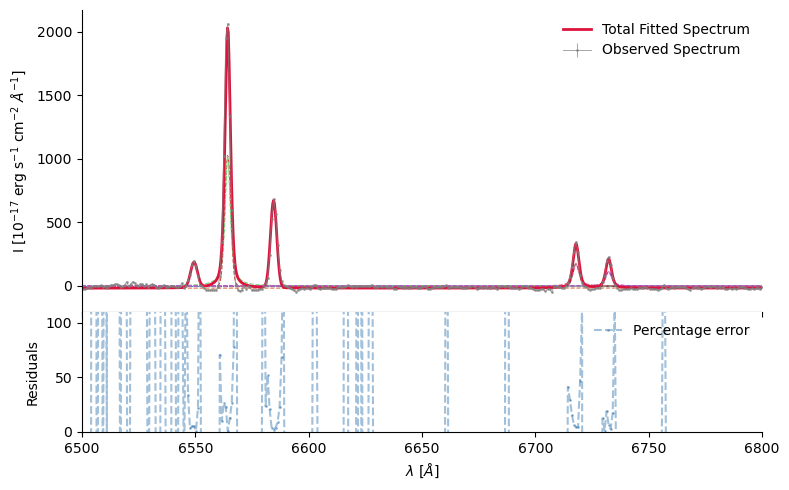

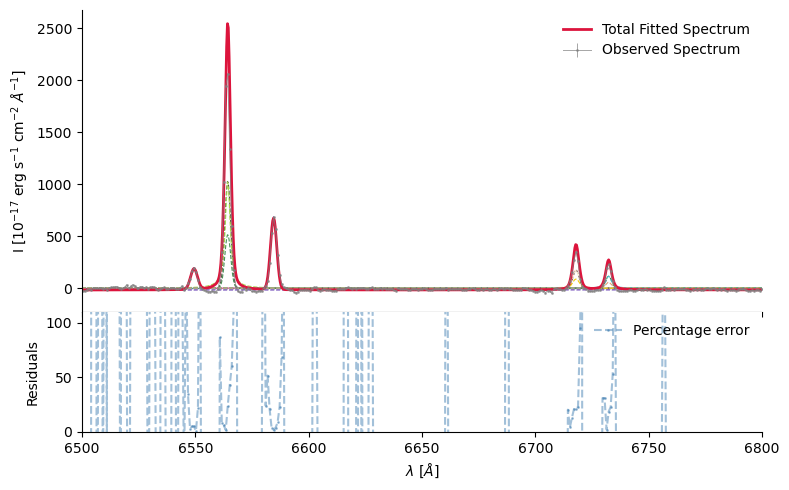

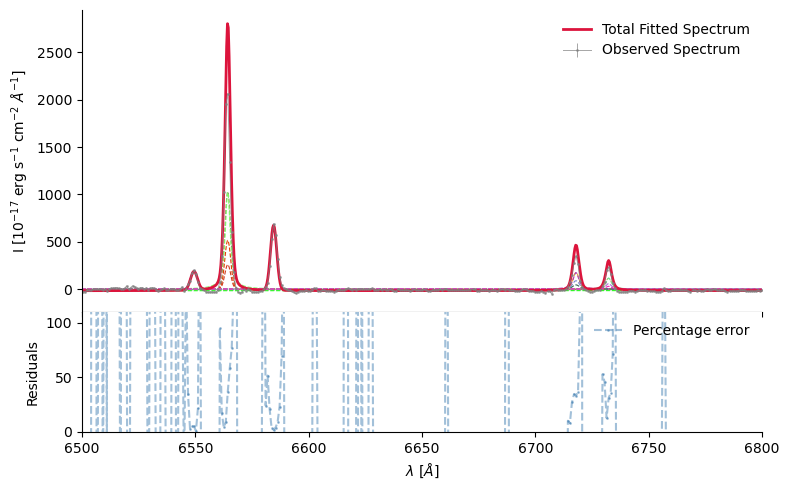

In [24]:
plot0 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], fit0, x_zoom=(6500, 6800)) #, x_zoom=(4800, 5050))
plot1 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf, x_zoom=(6500, 6800))
plot2 = sps.spl_plot(spec0[:, 0], spec0[:, 1], spec0[:, 2], newdf2, x_zoom=(6500, 6800))

### Remarks for this week for 19 - 23 August

Hi Aksita,
I've already uploaded a set of many AGN spectra, in the route inside the new_spl folder:

new_spl/input_data

please consider from now the paths accordingly. This folder contain:
* MaNGA integrated (single) spectra; the nomenclature for this files is:
_manga-plate-ifu-*Reff*.fits_. These are integrating at different apertures, that is OK, we are seeking to adapt the code to properly work on an heterogeneous sample of spectra.
* PAQS simulated spectra. These are simulated quasar spectra produced to calibrate the 4MOST (a survey still to be launched) reduction pipeline. The nomenclature of these files is: _PAQS_OBJECTID_LJ1.fits_
* There is one complete manga cube: _manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits_
you can explore this fits cube either with a tool like qfitsview or directly with python, with the astropy.io.fits package (which I recommend)

By now, I would ask you to:

* Explore (that is; open, extract, and plot) these spectra.
* Work on a function to iterate over a list of files, open the spectra, and store them in a common object with identifiers (maybe a dictionary containing SNR, spectra, redshift) to afterwards apply the process we have worked on. This execution might be useful at once because that might be the most efficient way to proceed for complete datacubes.
* Calculate redshift using [OIII] or determine systemic redshift with other elements, and SNR

Start diving into this for this week, meanwhile I review and translate into a script what we have done until now.

Cheers, and see you on Wednesday!



###One MANGA Cube

In [25]:
import ipywidgets as widgets
from IPython.display import display

In [26]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz')
hdu_file = fits.open(fitsfile)

hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-11831-12702-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     126   ()      
  1  FLUX          1 ImageHDU        45   (74, 74, 4563)   float32   
  2  IVAR          1 ImageHDU        46   (74, 74, 4563)   float32   
  3  MASK          1 ImageHDU        45   (74, 74, 4563)   int16   
  4  LSF           1 ImageHDU        44   (74, 74, 4563)   float32   
  5  WAVE          1 ImageHDU         9   (4563,)   float32   
  6  REDCORR       1 ImageHDU         9   (4563,)   float32   
  7  MODEL         1 ImageHDU        44   (74, 74, 4563)   float32   
  8  MODEL_MASK    1 ImageHDU        44   (74, 74, 4563)   int16   
  9  EMLINE        1 ImageHDU        43   (74, 74, 4563)   float32   
 10  STELLAR       1 ImageHDU        44   (74, 74, 4563)   float32   
 11  STELLAR_MASK    1 ImageHDU        44   (74, 74, 4563)   int16   
 12  BINID     

In [27]:
mangaflux = hdu_file['FLUX'].data
mangawave = hdu_file['WAVE'].data
mangaerr = hdu_file['IVAR'].data

In [28]:
def visualise_cube_slice(wavelength_index):
    image_slice = mangaflux[wavelength_index, :, :]
    plt.imshow(image_slice, cmap='viridis')
    plt.title(f"Heatmap for Wavelength Index {wavelength_index}")
    plt.xlabel("x pix")
    plt.ylabel("y pix")
    plt.colorbar()
    plt.show()

# slider widget to select the wavelength index
wavelength_slider = widgets.IntSlider(min=0, max=mangaflux.shape[0]-1, value=0, description='WV')

# connect the slider to the cube visualiser function
widgets.interact(visualise_cube_slice, wavelength_index=wavelength_slider);

interactive(children=(IntSlider(value=0, description='WV', max=4562), Output()), _dom_classes=('widget-interac…

In [29]:
def visualise_data_slice(xpix,ypix):
    data_slice = mangaflux[:, ypix, xpix]
    plt.plot(data_slice)
    plt.title("Spectrum for Pixel [{}, {}]".format(xpix,ypix))
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.show()

# slider widget to select the x and y pixel index
ex = widgets.IntSlider(min=0, max=mangaflux.shape[1]-1, value=0, description='X')
why = widgets.IntSlider(min=0, max=mangaflux.shape[2]-1, value=0, description='Y')


# connect the slider to the flux spectra function
widgets.interact(visualise_data_slice, xpix=ex,ypix=why);

interactive(children=(IntSlider(value=0, description='X', max=73), IntSlider(value=0, description='Y', max=73)…

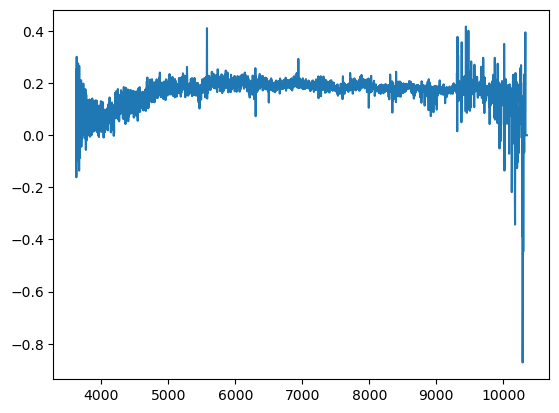

In [30]:
# for further investigation

xpix = 30
ypix = 40

plt.plot(mangawave, mangaflux[:,xpix,ypix])
plt.show()

### One MANGA file

In [31]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits')
hdu_file = fits.open(fitsfile)

hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     28   4563R x 4C   [D, D, D, D]   


In [32]:
data = hdu_file[1].data
data

FITS_rec([( 3621.59594727, 44.41267632, 2.02499509e+01, 0.        ),
          ( 3622.42993164, 51.74563035, 2.03599717e+01, 0.        ),
          ( 3623.26416016, 51.41560511, 2.03375225e+01, 0.        ), ...,
          (10349.03808594, 41.82240656, 3.08141064e+01, 0.84116068),
          (10351.421875  , 43.83776428, 3.25047681e+01, 0.67852876),
          (10353.80566406,  0.        , 2.16999999e-04, 0.        )],
         dtype=(numpy.record, [('wavelength', '>f8'), ('flux', '>f8'), ('flux_error', '>f8'), ('emlines', '>f8')]))

In [33]:
hdu_file[1].data['emlines']

array([0.        , 0.        , 0.        , ..., 0.84116068, 0.67852876,
       0.        ], dtype='>f8')

In [34]:
manga_wave = data['wavelength']
manga_flux = data['flux']
manga_error = data['flux_error']

print("Wavelength has shape ", len(manga_wave))
print("Flux has shape ", len(manga_flux))
print("Error has shape ", len(manga_error))

Wavelength has shape  4563
Flux has shape  4563
Error has shape  4563


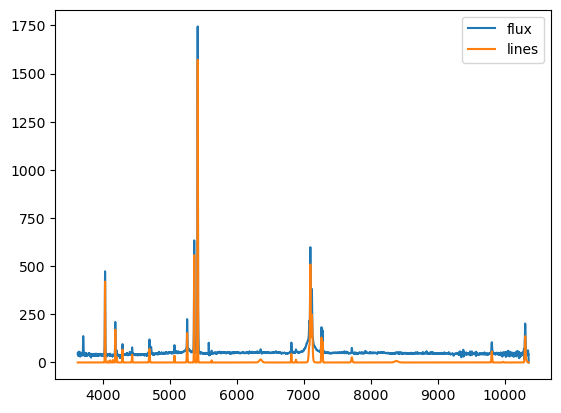

In [35]:
plt.plot(manga_wave, manga_flux, label ='flux')
plt.plot(manga_wave,hdu_file[1].data['emlines'],label ='lines')

plt.legend()
plt.show()

In [36]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits')
hdu_file = fits.open(fitsfile)

hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   4487R x 3C   [D, D, D]   


In [37]:
data = hdu_file[1].data
data

FITS_rec([( 3622. , 0.        , 0.00981665),
          ( 3623.5, 8.77098411, 0.12787415),
          ( 3625. , 0.        , 0.01846641), ...,
          (10348. , 0.86182812, 0.00978758),
          (10349.5, 0.86182812, 0.00978758),
          (10351. , 1.8603479 , 0.02469584)],
         dtype=(numpy.record, [('wavelength', '>f8'), ('flux_lines', '>f8'), ('flux_error', '>f8')]))

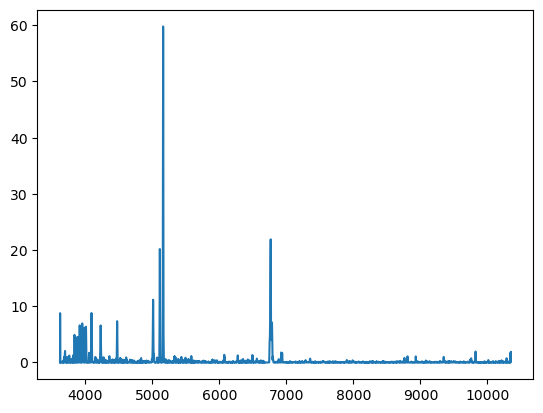

In [39]:
plt.plot(hdu_file[1].data['wavelength'], hdu_file[1].data['flux_lines'])
plt.show()

In [40]:
index5000 = np.argmin(np.abs(hdu_file[1].data['wavelength'] - 5000))
print(index5000)

919


### PAQS

In [41]:
fitsfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits')
hdu_file = fits.open(fitsfile)

hdu_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  PHASE3SPECTRUM    1 BinTableHDU     88   1R x 6C   [23198E, 23198E, 23198E, 23198J, 23198E, 23198E]   


In [42]:
data = hdu_file[1].data
data

FITS_rec([([3700.25, 3700.5 , 3700.75, ..., 9499.  , 9499.25, 9499.5 ], [-6.67236969e-18,  3.03505735e-17,  2.82424641e-17, ...,  9.99461406e-18,  9.08961726e-18,  2.30339836e-18], [3.29998081e-17, 3.29965159e-17, 3.29423124e-17, ..., 3.59508866e-18, 3.46677867e-18, 3.17022016e-18], [0, 0, 0, ..., 0, 0, 0], [ 6.84311259e-18,  4.48088535e-17,  4.30890590e-17, ...,  2.36157517e-17,  2.17745238e-17,  1.30340967e-17], [3.29998081e-17, 3.29965159e-17, 3.29423124e-17, ..., 3.59508866e-18, 3.46677867e-18, 3.17022016e-18])],
         dtype=(numpy.record, [('WAVE', '>f4', (23198,)), ('FLUX', '>f4', (23198,)), ('ERR_FLUX', '>f4', (23198,)), ('QUAL', '>i4', (23198,)), ('FLUX_NOSS', '>f4', (23198,)), ('ERR_FLUX_NOSS', '>f4', (23198,))]))

In [43]:
paqs_wave = data['WAVE']
paqs_flux = data['FLUX']
paqs_error = data['ERR_FLUX']

print("Wavelength has shape ", len(paqs_wave))
print("Flux has shape ", len(paqs_flux))
print("Error has shape ", len(paqs_error))

Wavelength has shape  1
Flux has shape  1
Error has shape  1


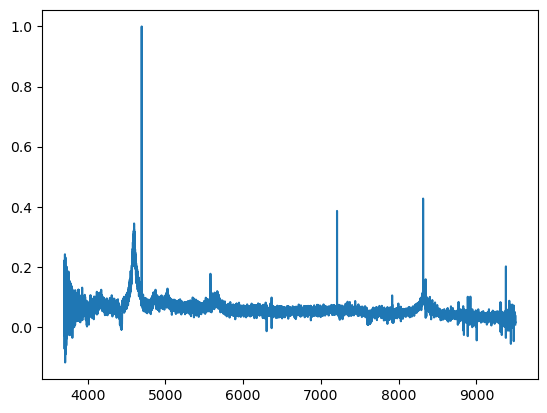

In [44]:
plt.plot(paqs_wave[0], paqs_flux[0]/max(paqs_flux[0]), label ='flux')

plt.show()

### Multiple files

In [45]:
def extract_data(array):
    """
    Extracts data from multidimensional arrays
    """

    if array.ndim == 1:
        return array
    elif array.ndim == 2:
        return array.flatten()
    else:
        raise ValueError("Unsupported array dimension: {}".format(array.ndim))

In [46]:
def extract_astronomical_data(filename, verbose=True, wavelength_name=None, flux_name=None, error_name=None):
    """
    Extracts wavelength, flux, and error (when applicable) from a FITS file,
    handling variations in keyword syntax and layout across surveys.

    Params:


    Future edits: Add dictionary of keywords from public data surveys? Or maybe a dictionary where user
    just has to define what survey it's from? If keyword not found and user knows keyword, maybe change
    function to have the option to add keyword? Possibly add 3D - 1D data analysis
    """

    try:
        with fits.open(filename) as hdul:

            # Search for keywords
            potential_keywords = ['wavelength', 'WAVE', 'lambda']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    wavelength_name = keyword
                    break

            potential_keywords = ['flux', 'FLUX', 'f_lambda', 'flux_lines','total flux']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    flux_name = keyword
                    break

            potential_keywords = ['error', 'ERR', 'flux_error', 'ERR_FLUX','flux error']
            for keyword in potential_keywords:
                if keyword in hdul[1].columns.names:
                    error_name = keyword
                    break

            # Define arrays
            if wavelength_name:
                wave = hdul[1].data[wavelength_name]
            else:
                if verbose:
                    print("Warning: Keyword for wavelength not found.")
                pass

            if flux_name:
                flux = hdul[1].data[flux_name]
            else:
                if verbose:
                    print("Warning: Keyword for flux not found.")
                pass

            if error_name:
                err = hdul[1].data[error_name]
            else:
                if verbose:
                    print("Warning: Keyword for error not found.")
                pass

            # Create spectra with same form as Jose Luis

            wave = extract_data(wave)
            flux = extract_data(flux)
            err = extract_data(err)

            spec = np.array([wave, flux, err]).T

            return spec

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

######Extract Redshift#### Extract SNR

In [47]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	}

In [48]:
from scipy.signal import find_peaks

In [49]:
# UNCOMMENT AFTER TESTING

def calculate_redshift(wavelength, flux, emission_lines):

    # Find emission line peaks
    peaks, _ = find_peaks(flux/max(flux), height=0.4)                                      # ADJUST
    wavepeaks = np.array(wavelength[peaks])

    # Generate a grid of redshifts
    redshifts = np.arange(0, 3.5, 0.01)

    # Calculate chi-squared values for each redshift
    chi_squared_values = []

    for redshift in redshifts:

        # Deredshift the spectrum
        deredshifted_wavelengths = wavepeaks / (1 + redshift)

        # Calculate chi-squared for each emission line
        chi_squared_line = []

        for line in emission_lines:
            # Define emission line
            rest_wavelength = emission_lines[line]['wavelength'][0]

            # Find the index of the closest value in the array
            closest_index = np.argmin(np.abs(deredshifted_wavelengths - rest_wavelength))

            # Get the closest value and the difference
            closest_value = deredshifted_wavelengths[closest_index]
            difference = np.abs(closest_value - rest_wavelength)

            chi_squared_line.append(difference)

        # Calculate total chi-squared for the redshift
        chi_squared_total = np.sum(chi_squared_line)
        chi_squared_values.append(chi_squared_total)


    # Find the redshift with the minimum chi-squared value
    best_redshift_index = np.argmin(chi_squared_values)
    best_redshift = redshifts[best_redshift_index]
    best_chi_squared = chi_squared_values[best_redshift_index]

    deredshifted_wavelengths1 = wavelength / (1 + best_redshift)

    return best_redshift, best_chi_squared

In [50]:
redshift,_ = calculate_redshift(paqs_wave[0], paqs_flux[0], SNR_emission_lines)
if redshift is not None:
    print(f"Calculated redshift: {redshift}")
else:
    print("No redshift could be calculated.")

Calculated redshift: 0.23


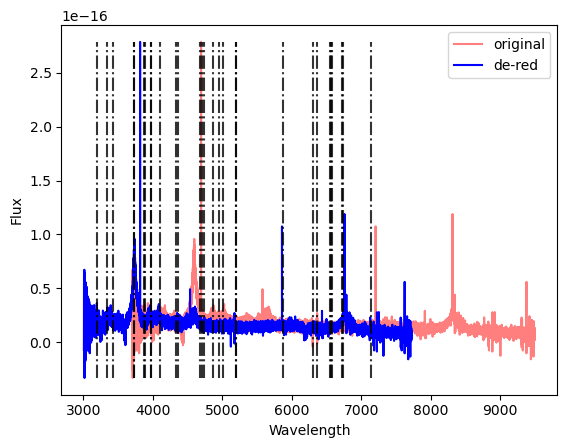

In [51]:
plt.plot(paqs_wave[0], paqs_flux[0], label ='original',color = 'red',alpha= 0.5)
plt.plot(paqs_wave[0]/(1+redshift), paqs_flux[0], label ='de-red',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(paqs_flux[0]),ymax=max(paqs_flux[0]), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [52]:
redshift,_ = calculate_redshift(manga_wave, manga_flux, SNR_emission_lines)
if redshift is not None:
    print(f"Calculated redshift: {redshift}")
else:
    print("No redshift could be calculated.")

Calculated redshift: 0.14


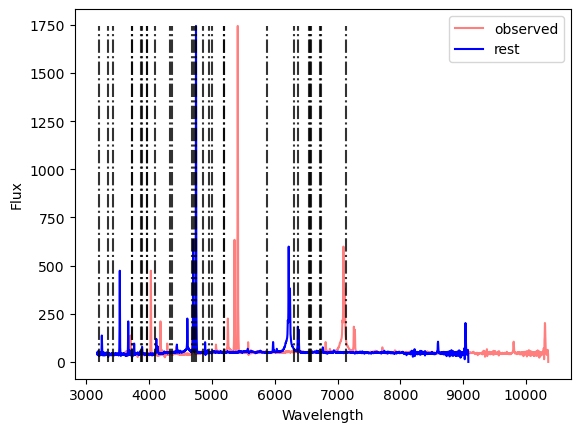

In [53]:
plt.plot(manga_wave, manga_flux, label ='observed',color = 'red',alpha= 0.5)
plt.plot(manga_wave/(1+redshift), manga_flux, label ='rest',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(manga_flux),ymax=max(manga_flux), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [54]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	'O VI': {'wavelength': [1033.82]},
	'Ly-alpha': {'wavelength': [1215.24]},
	'N V': {'wavelength': [1305.53]},
	'Si IV + O IV': {'wavelength': [1549.48]},
	'C IV': {'wavelength': [1640.40]},
	'C III': {'wavelength': [2326.00]},
	'Mg II': {'wavelength': [3346.79]},
	}

In [55]:
# UNCOMMENT AFTER TESTING

def calculate_redshift(spectrum, emission_lines):

    wavelength = spectrum[:, 0]
    flux = spectrum[:, 1]
    errors = spectrum[:, 2]

    # Find emission line peaks
    peaks, _ = find_peaks(flux/max(flux), height=0.4)                                      # ADJUST
    wavepeaks = np.array(wavelength[peaks])

    # Generate a grid of redshifts
    redshifts = np.arange(0, 3.5, 0.01)

    # Calculate chi-squared values for each redshift
    chi_squared_values = []

    for redshift in redshifts:

        # Deredshift the spectrum
        deredshifted_wavelengths = wavepeaks / (1 + redshift)

        # Calculate chi-squared for each emission line
        chi_squared_line = []

        for line in emission_lines:
            # Define emission line
            rest_wavelength = emission_lines[line]['wavelength'][0]

            # Find the index of the closest value in the array
            closest_index = np.argmin(np.abs(deredshifted_wavelengths - rest_wavelength))

            # Get the closest value and the difference
            closest_value = deredshifted_wavelengths[closest_index]
            difference = np.abs(closest_value - rest_wavelength)

            chi_squared_line.append(difference)

        # Calculate total chi-squared for the redshift
        chi_squared_total = np.sum(chi_squared_line)
        chi_squared_values.append(chi_squared_total)


    # Find the redshift with the minimum chi-squared value
    best_redshift_index = np.argmin(chi_squared_values)
    best_redshift = redshifts[best_redshift_index]
    best_chi_squared = chi_squared_values[best_redshift_index]

    deredshifted_wavelengths1 = wavelength / (1 + best_redshift)

    return best_redshift, best_chi_squared

#####Extract Redshift P.2

In [56]:
SNR_emission_lines = {
  'He-II,1': {'wavelength': [3202.15]},
  'He-II,2': {'wavelength': [4685.74]},
  'Ne-V,1':  {'wavelength': [3345.81]},
  'Ne-V,2':  {'wavelength': [3425.81]},
  'O-II,1':  {'wavelength': [3726.03]},
  'O-II,2':  {'wavelength': [3728.73]},
  'Ne-III,1': {'wavelength': [3868.69]},
  'Ne-III,2': {'wavelength': [3967.40]},
  'H-ζ':    {'wavelength': [3889.05]},
  'H-ε':    {'wavelength': [3970.07]},
  'H-δ':    {'wavelength': [4101.73]},
  'H-γ':    {'wavelength': [4340.46]},
  'O-III,0':  {'wavelength': [4363.15]},
  'O-III,1':  {'wavelength': [4958.83]},
  'O-III,2':  {'wavelength': [5006.77]},
  'Ar-IV,1':  {'wavelength': [4711.30]},
  'Ar-IV,2':  {'wavelength': [4740.10]},
  'H-β':     {'wavelength': [4861.32]},
  'N-I,1':    {'wavelength': [5197.90]},
  'N-I,2':    {'wavelength': [5200.39]},
  'He-I':   {'wavelength': [5875.60]},
  'O-I,1':   {'wavelength': [6300.20]},
  'O-I,2':   {'wavelength': [6363.67]},
  'N-II,1':   {'wavelength': [6547.96]},
  'N-II,2':   {'wavelength': [6583.34]},
  'H-α':     {'wavelength': [6562.80]},
  'S-II,1':  {'wavelength': [6716.31]},
  'S-II,2':   {'wavelength': [6730.68]},
  'Ar-III': {'wavelength': [7135.67]},
  'O VI': {'wavelength': [1033.82]},
  'Ly-alpha': {'wavelength': [1215.24]},
  'N V': {'wavelength': [1305.53]},
  'C II': {'wavelength': [1397.61]},
  'Si IV': {'wavelength': [1399.80]},
  'C IV': {'wavelength': [1640.40]},
  'He II': {'wavelength': [1665.85]},
  'Al III': {'wavelength': [1908.73]},
  'Mg II': {'wavelength': [3346.79]},
  'Ne VI': {'wavelength': [3727.09]}
}

In [57]:
!pip install specutils

In [58]:
print(np.__version__)

1.26.4


[1. 2. 3.]
[4000. 5000. 6000.] Angstrom



<WCSAxes: ylabel='Data []'>

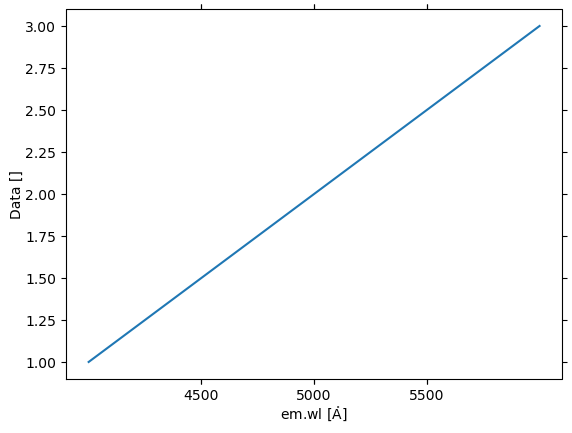

In [59]:
from specutils import Spectrum1D
import astropy.units as u


# Create a Spectrum1D object
# Flux and wavelength data (no explicit units)
flux = np.array([1, 2, 3]) * u.dimensionless_unscaled
wavelength = np.array([4000, 5000, 6000]) * u.angstrom

# Create a Spectrum1D object without units (not recommended)
spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength);

# Access properties
print(spectrum.flux)  # Output: [1 2 3]
print(spectrum.wavelength)  # Output: [4000 5000 6000]
print(spectrum.unit)  # Output: Angstrom

# Plot the spectrum
spectrum.plot()

In [60]:
from specutils.analysis import template_match
from specutils import Spectrum1D
# from specutils.uncertainty import StdDevUncertainty

from astropy.nddata import StdDevUncertainty

In [61]:
tempfile = ('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/liner_template.fits')
temp_file = fits.open(tempfile)

temp_file.info()

Filename: /Users/aksitadeo/PycharmProjects/spelfig_aksita/template/liner_template.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1                1 BinTableHDU     16   1264R x 2C   [1E, 1E]   


In [62]:
tdata = temp_file[1].data
tdata['WAVELENGTH']

array([1235., 1240., 1245., ..., 7540., 7545., 7550.], dtype='>f4')

In [63]:
template_spectra = []

dir = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/'
template_filenames = [f for f in os.listdir(dir) if f.endswith('.fits')]

for filename in template_filenames:
    full_dir = os.path.join(dir, filename)
    template_data = fits.open(full_dir)

    wavelength = template_data[1].data['WAVELENGTH'] * u.Angstrom
    flux = template_data[1].data['FLUX'] * u.Jy

    spect0 = Spectrum1D(flux=flux, spectral_axis=wavelength)
    template_spectra.append(spect0)

In [64]:
testerdata = Spectrum1D(flux=manga_flux * u.Jy, spectral_axis=manga_wave * u.Angstrom, uncertainty = StdDevUncertainty(manga_error), unit='Jy')

testerred = np.arange(0.05, 2.4, 0.01)

In [65]:
normspec, redshiftspec, chiindexspec, chiminspec, chilist = template_match(testerdata, template_spectra, redshift=testerred)

In [66]:
redshiftspec

0.08000000000000002

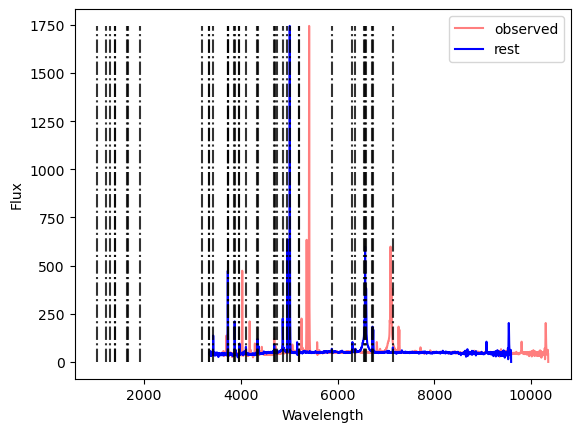

In [68]:
plt.plot(manga_wave, manga_flux, label ='observed',color = 'red',alpha= 0.5)
plt.plot(manga_wave/(1+redshiftspec), manga_flux, label ='rest',color='blue', alpha = 1)

# Plot vertical lines for emission lines
for line_name, line_data in SNR_emission_lines.items():
    for rest_wavelength in line_data['wavelength']:
        plt.vlines(rest_wavelength,ymin=min(manga_flux),ymax=max(manga_flux), color='black', linestyle='-.',alpha = 0.8)
        # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)

plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend()
plt.show()

In [86]:
def redshift_templ(spectrum, Plot=False):

  wavelength = spectrum[:, 0]
  fluxes = spectrum[:, 1]
  errors = spectrum[:, 2]

  speconed_data = Spectrum1D(flux=fluxes * u.Jy, spectral_axis=wavelength * u.Angstrom, uncertainty = StdDevUncertainty(errors), unit='Jy')
  redshift_range = np.arange(0.05, 2.49, 0.01)

  normspec, redshiftspec, chiindexspec, chiminspec, chilist = template_match(speconed_data, template_spectra, redshift=redshift_range)
  
  if Plot==True:
      plt.plot(wavelength, fluxes, label ='observed',color = 'red',alpha= 0.5)
      plt.plot(wavelength/(1+redshiftspec), fluxes, label ='rest',color='blue', alpha = 1)
        
        # Plot vertical lines for emission lines
      for line_name, line_data in SNR_emission_lines.items():
          for rest_wavelength in line_data['wavelength']:
              plt.vlines(rest_wavelength,ymin=min(fluxes),ymax=max(fluxes), color='black', linestyle='-.',alpha = 0.8)
                # plt.axvline(rest_wavelength, color='black', linestyle='--',alpha = 0.2)
        
      plt.xlabel('Wavelength')
      plt.ylabel('Flux')
        
      plt.legend()
      plt.show()
      
      
  return redshiftspec

In [116]:
import redshifts as reds 

In [117]:
reds.initialise_templates('/Users/aksitadeo/PycharmProjects/spelfig_aksita/template/')

[<Spectrum1D(flux=[5.287767497626737e-14 ... 1.5843080428297462e-14] Jy (shape=(2081,), mean=0.00000 Jy); spectral_axis=<SpectralAxis [ 800.   802.5  805.  ... 5995.  5997.5 6000. ] Angstrom> (length=2081))>]

#####Extract SNR

In [75]:
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

In [76]:
SNR_emission_lines = {
	'He-II,1': {'wavelength':[3202.15]},
	'He-II,2': {'wavelength':[4685.74]},
	'Ne-V,1':  {'wavelength':[3345.81]},
	'Ne-V,2':  {'wavelength':[3425.81]},
	'O-II,1':  {'wavelength':[3726.03]},
	'O-II,2':  {'wavelength':[3728.73]},
	'Ne-III,1': {'wavelength':[3868.69]},
	'Ne-III,2': {'wavelength':[3967.40]},
	'H-ζ':    {'wavelength':[3889.05]},
	'H-ε':    {'wavelength':[3970.07]},
	'H-δ':    {'wavelength':[4101.73]},
	'H-γ':    {'wavelength':[4340.46]},
	'O-III,0':  {'wavelength':[4363.15]},
	'O-III,1':  {'wavelength':[4958.83]},
	'O-III,2':  {'wavelength':[5006.77]},
	'Ar-IV,1':  {'wavelength':[4711.30]},
	'Ar-IV,2':  {'wavelength':[4740.10]},
	'H-β':     {'wavelength':[4861.32]},
	'N-I,1':    {'wavelength':[5197.90]},
	'N-I,2':    {'wavelength':[5200.39]},
	'He-I':   {'wavelength':[5875.60]},
	'O-I,1':   {'wavelength':[6300.20]},
	'O-I,2':   {'wavelength':[6363.67]},
	'N-II,1':   {'wavelength':[6547.96]},
	'N-II,2':   {'wavelength':[6583.34]},
	'H-α':     {'wavelength':[6562.80]},
	'S-II,1':  {'wavelength': [6716.31]},
	'S-II,2':   {'wavelength':[6730.68]},
	'Ar-III': {'wavelength':[7135.67]},
	'O VI': {'wavelength': [1033.82]},
	'Ly-alpha': {'wavelength': [1215.24]},
	'N V': {'wavelength': [1305.53]},
	'Si IV + O IV': {'wavelength': [1549.48]},
	'C IV': {'wavelength': [1640.40]},
	'C III': {'wavelength': [2326.00]},
	'Mg II': {'wavelength': [3346.79]},
	}

In [77]:
SNR_emission_lines['O-III,0']['wavelength'][0]

4363.15

In [78]:
def extract_snr(spectrum, redshift, line=None):

  wavelength = spectrum[:, 0]/(1+redshift)
  flux = spectrum[:, 1]
  errors = spectrum[:, 2]

  # Select which line from the emission lines to use
  rest_wavelength = SNR_emission_lines[line]['wavelength'][0] if line is not None else SNR_emission_lines['O-III,0']['wavelength'][0]

  # Identify the correct peaks
  lower_bound = rest_wavelength - 30
  upper_bound = rest_wavelength + 30
  mask = (wavelength >= lower_bound) & (wavelength <= upper_bound)
  window_flux = flux[mask]
  window_wavelengths = wavelength[mask]

  peaks, _ = find_peaks(window_flux, prominence=0.5)
  closest_peak_idx = None
  min_diff = float('inf')

  for peak_idx in peaks:

    observed_wavelength = window_wavelengths[peak_idx]
    diff = abs(observed_wavelength - rest_wavelength)

    if diff < min_diff:
        min_diff = diff
        closest_peak_idx = peak_idx

  if closest_peak_idx is not None:
      peak_flux = window_flux[peak_idx]

  else:
      print("Closest peak index not found for line:", line)

  # Define continuum

  continuum_mask = (wavelength >= lower_bound) & (wavelength <= upper_bound)
  continuum_data = flux[continuum_mask]
  continuum_wavelengths = wavelength[continuum_mask]

  continuum_fit = np.polyfit(continuum_wavelengths, continuum_data, deg=1)
  continuum_model = np.polyval(continuum_fit, continuum_wavelengths)

  local_std = np.std(continuum_model)
  local_mean = np.mean(continuum_model)

  # Define SNR
  snr = (peak_flux - local_mean) / local_std if local_std > 0 else print('huh')
  print('SNR is ', snr)

  return snr

####**Final Function**

In [79]:
spec_dict = {

    'ID' : [],
    'SPECTRA': [],
    'SNR' : [],
    'REDSHIFT' : []

             }

/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000439.86-271539.36_LJ1.fits


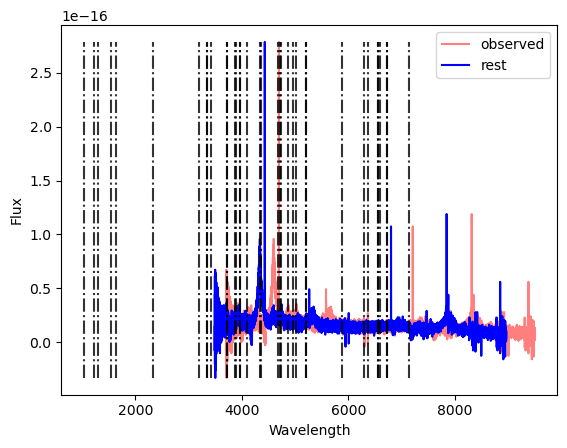

Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/magpi2304104201_aperture_1.25R50_ppxf.fits


/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/aksitadeo/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = sup

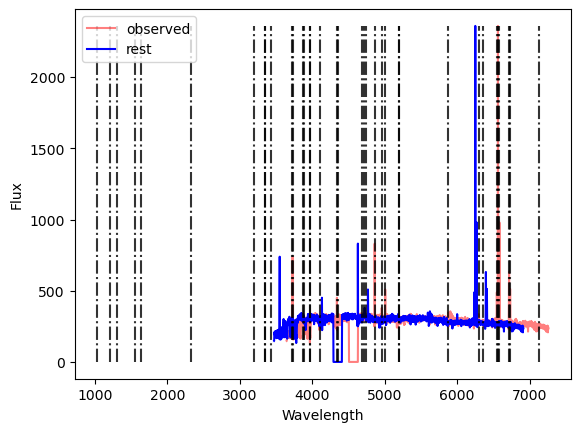

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
huh
SNR is  None
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_013700.03-333858.58_LJ1.fits


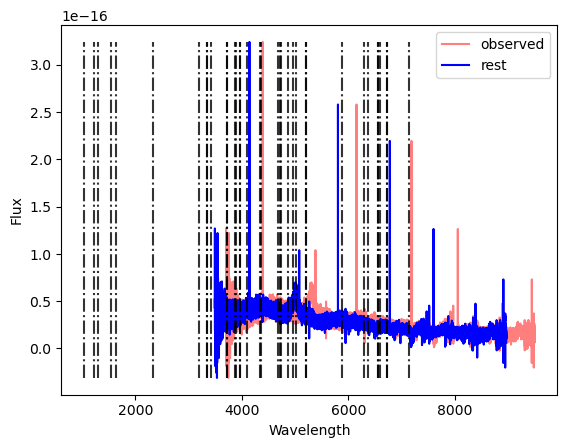

Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_011708.49-191258.11_LJ1.fits


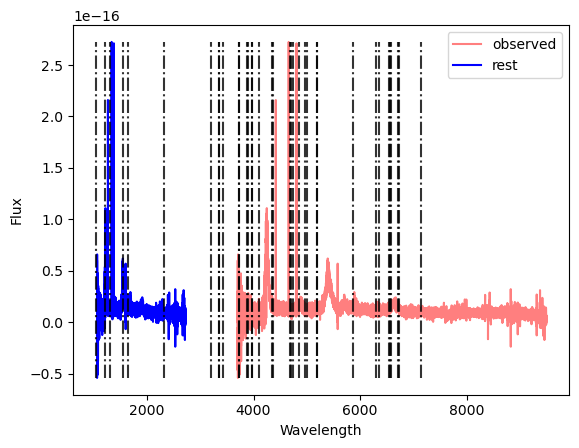

Has a redshift of  2.4900000000000007
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000351.38-153220.14_LJ1.fits


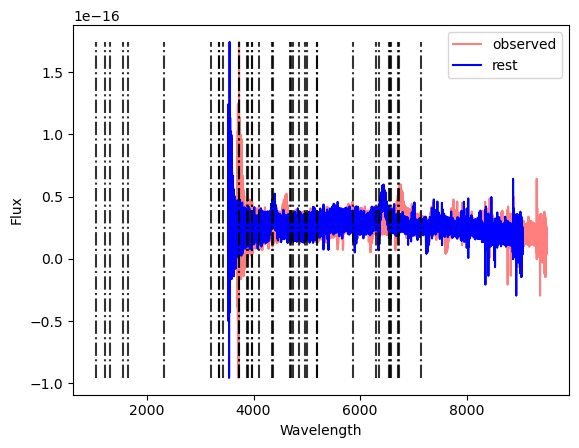

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000153.90-215901.05_LJ1.fits


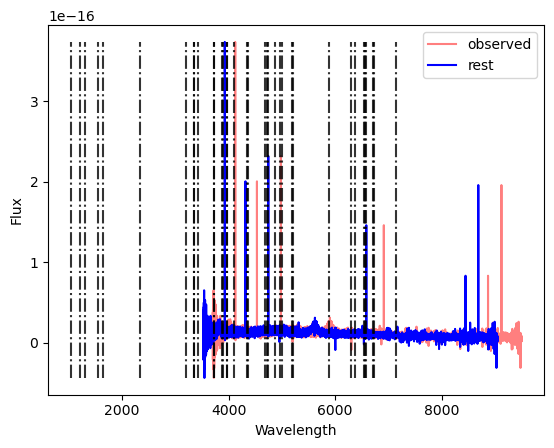

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_021149.04-260810.71_LJ1.fits


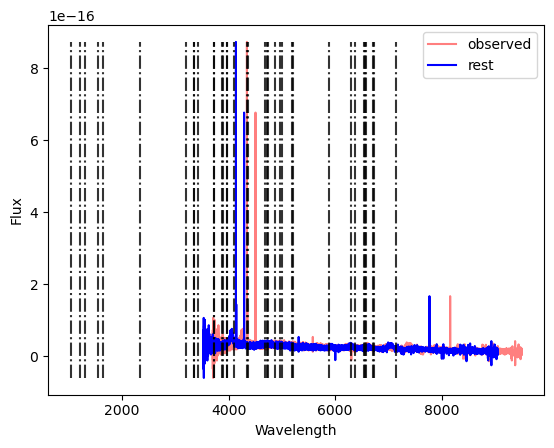

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002742.94-293946.14_LJ1.fits


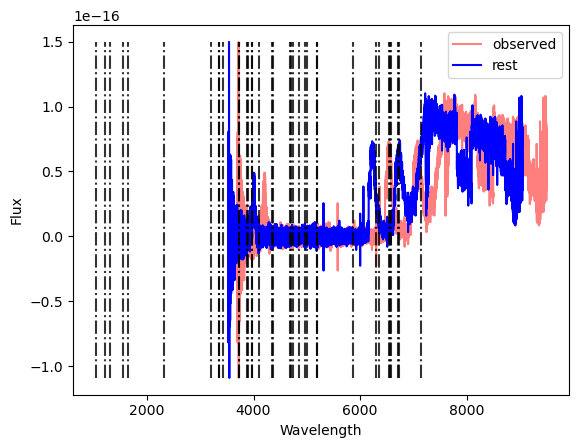

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014817.88-615640.60_LJ1.fits


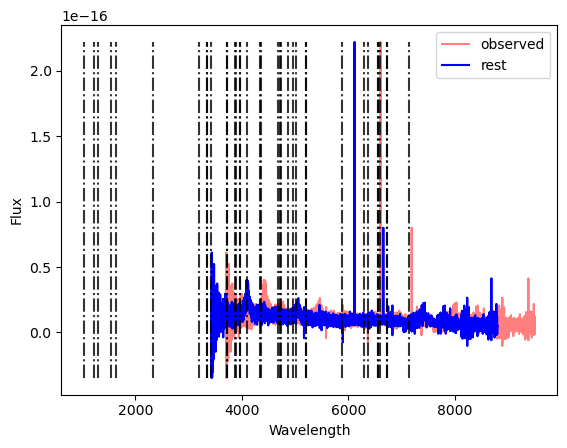

Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_023018.71-551419.94_LJ1.fits


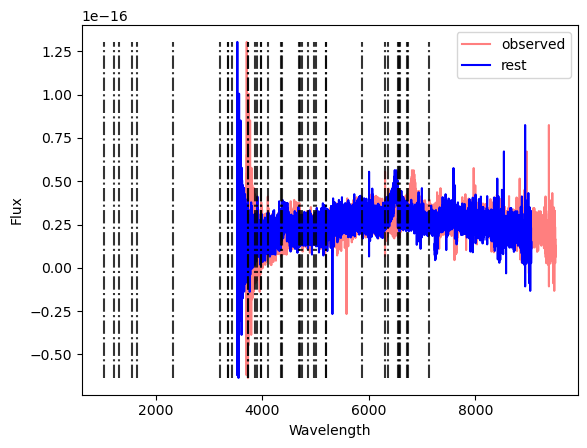

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_005214.83-513256.07_LJ1.fits


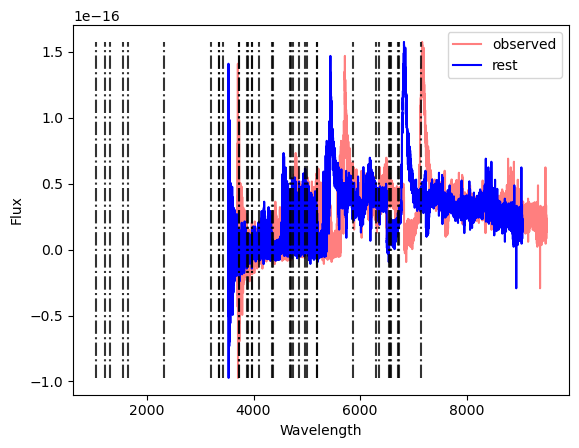

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_003936.39-363904.01_LJ1.fits


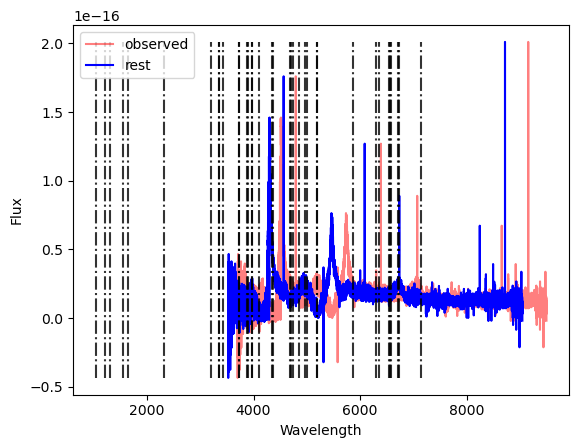

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_030347.63-233455.49_LJ1.fits


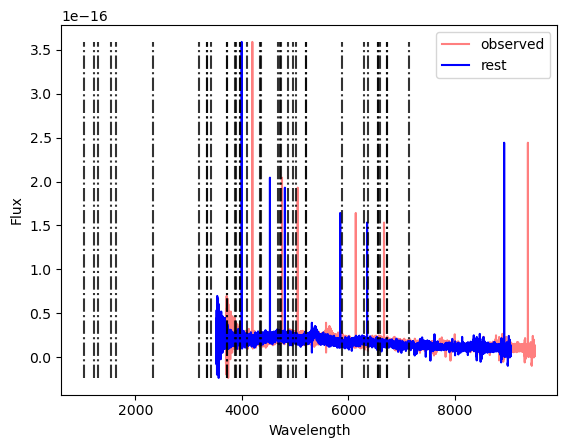

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_022444.84-625501.78_LJ1.fits


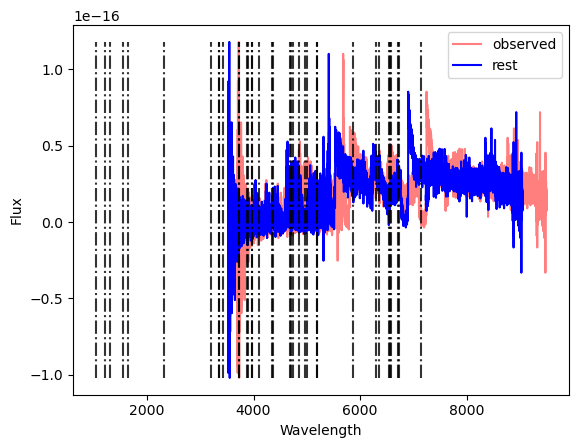

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104-0.5Reff-DAP.fits


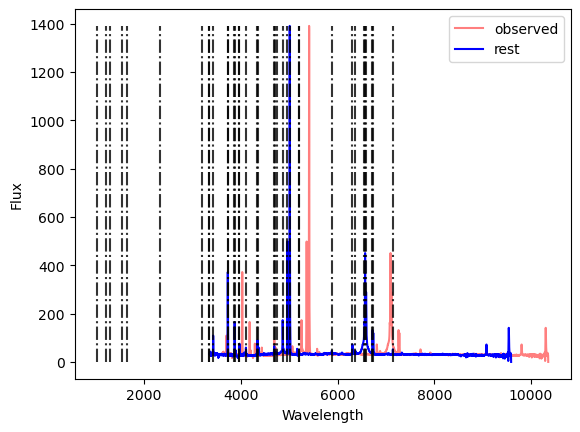

Has a redshift of  0.08000000000000002
SNR is  -1.2842317858009236
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_012718.76-292642.57_LJ1.fits


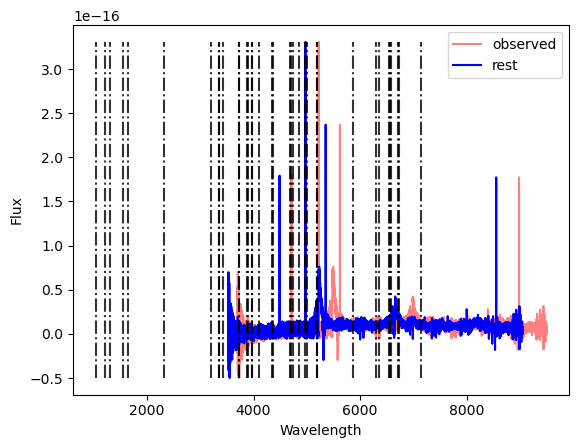

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_023852.89-552941.58_LJ1.fits


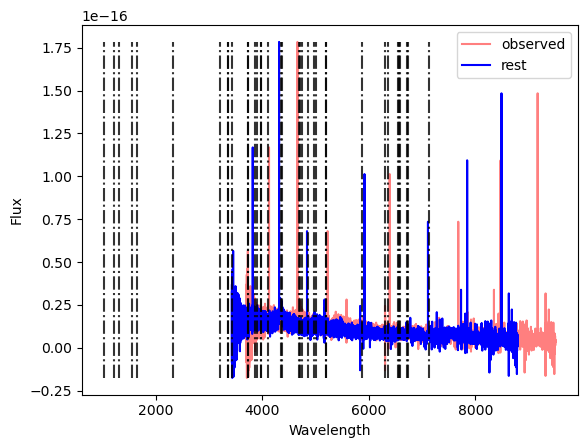

Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002140.16-415827.99_LJ1.fits


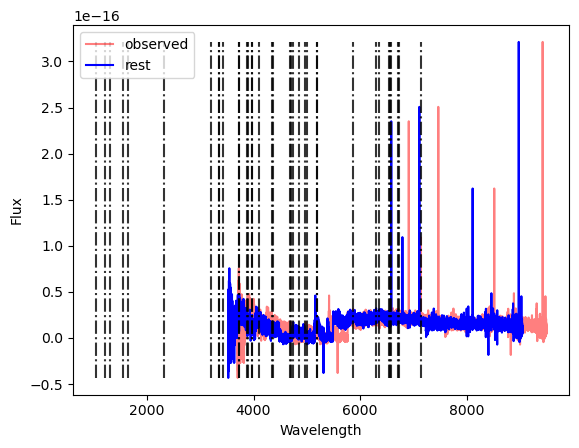

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024537.77-211635.19_LJ1.fits


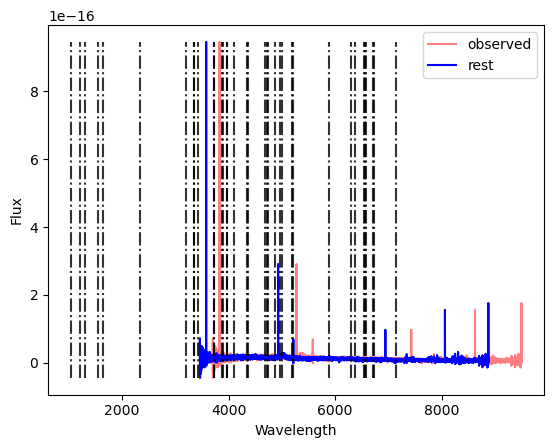

Has a redshift of  0.07
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000537.14-192913.35_LJ1.fits


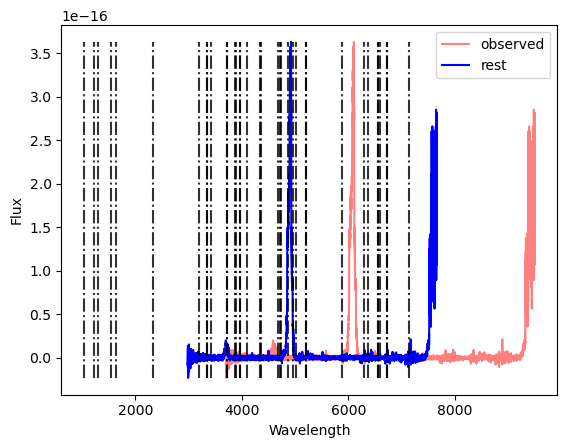

Has a redshift of  0.24000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000047.09-302857.50_LJ1.fits


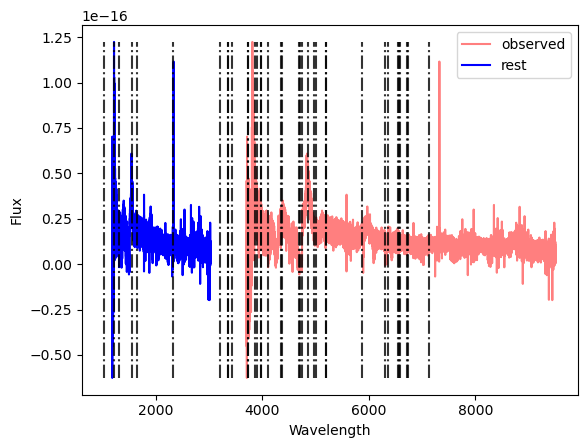

Has a redshift of  2.1400000000000006
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_022233.90-513102.95_LJ1.fits


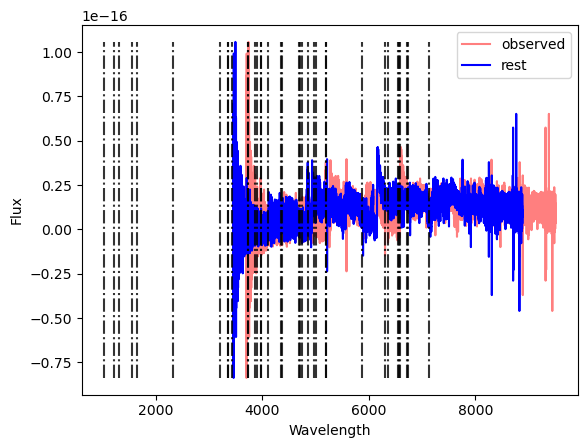

Has a redshift of  0.07
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024533.09-490220.28_LJ1.fits


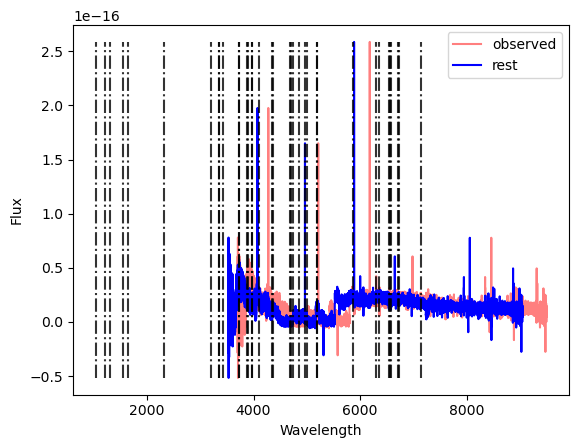

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_021915.28-600523.07_LJ1.fits


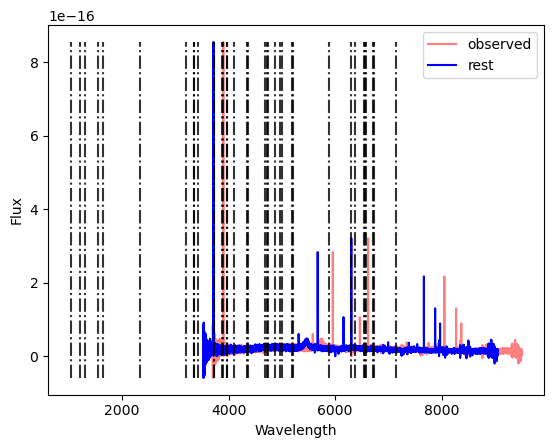

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014243.22-302233.55_LJ1.fits


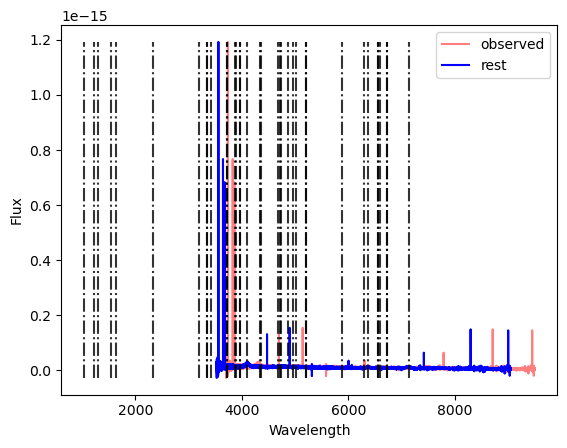

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_002021.46-665821.09_LJ1.fits


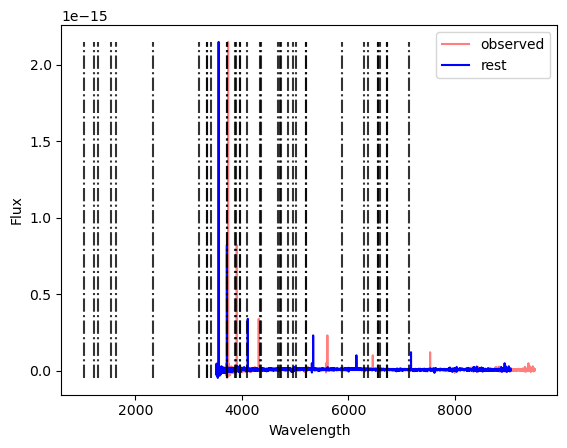

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_020745.73-470008.79_LJ1.fits


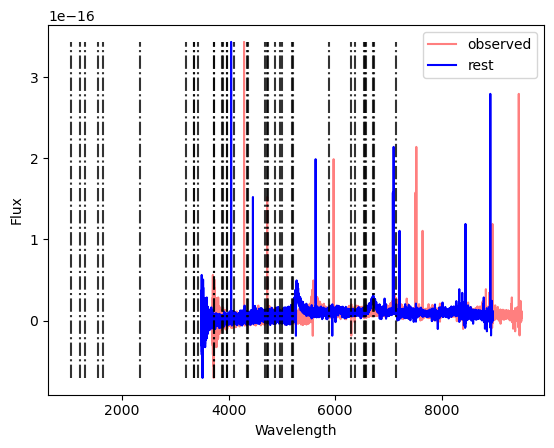

Has a redshift of  0.060000000000000005
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_014708.79-412307.52_LJ1.fits


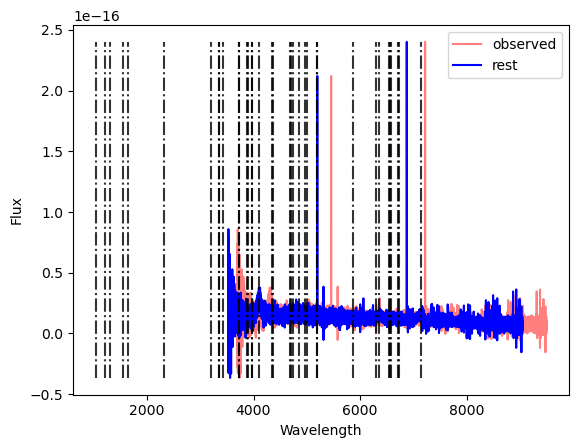

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_020758.99-385951.03_LJ1.fits


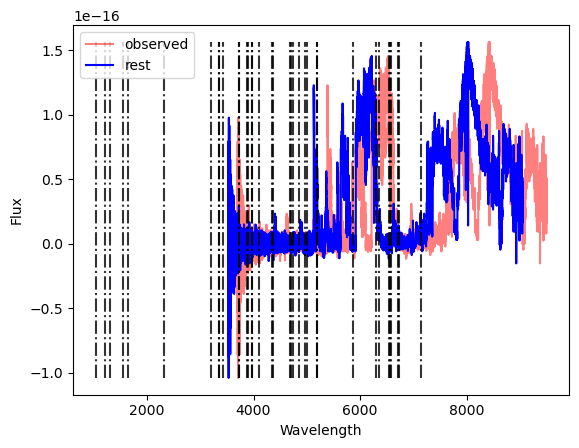

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_003215.86-354217.00_LJ1.fits


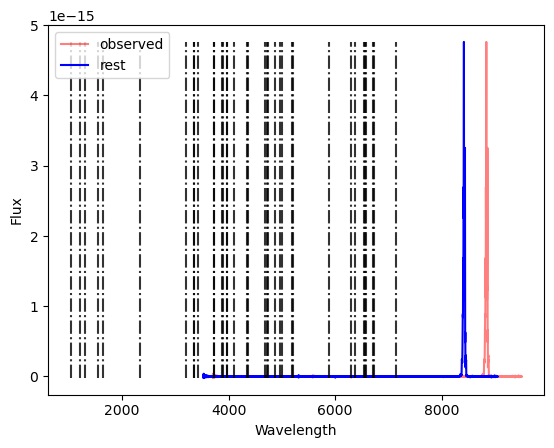

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_025041.57-195009.73_LJ1.fits


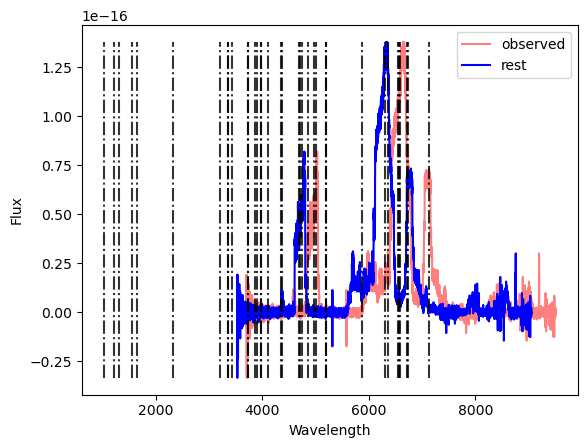

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_000648.35-294017.52_LJ1.fits


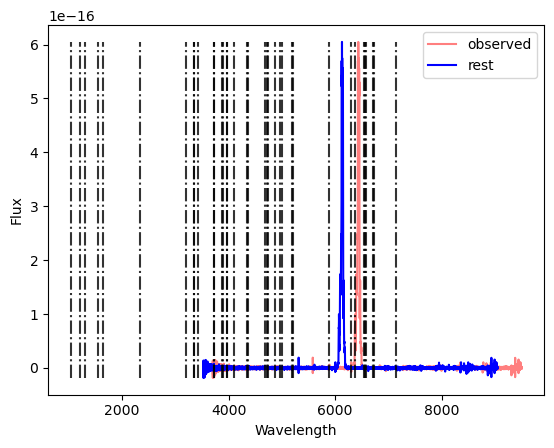

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_030604.29-344406.70_LJ1.fits


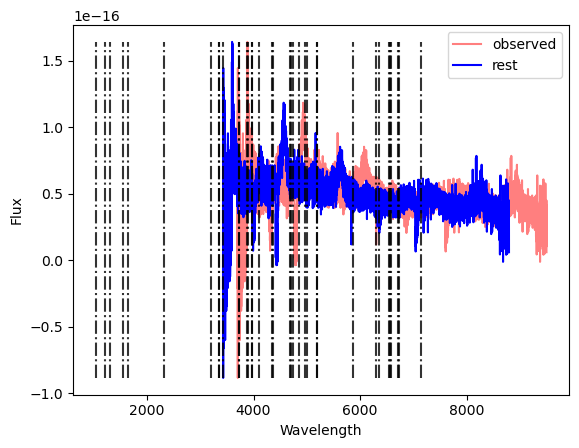

Has a redshift of  0.08000000000000002
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_004527.50-203625.10_LJ1.fits


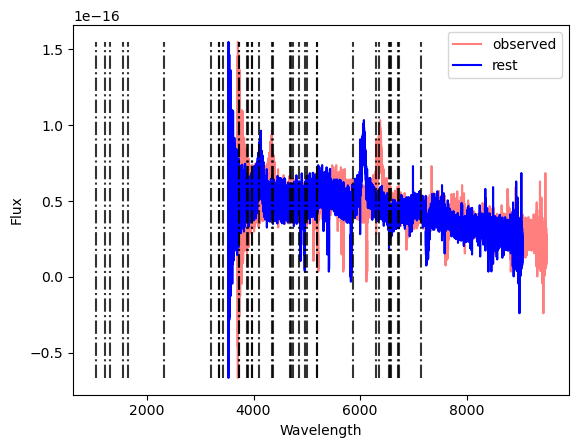

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8089-12705_Reff_spec.fits


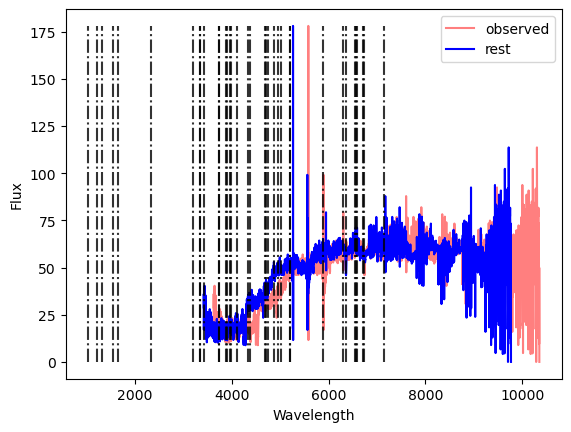

Has a redshift of  0.060000000000000005
SNR is  1.83293750818969
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/PAQS_024205.49-202955.55_LJ1.fits


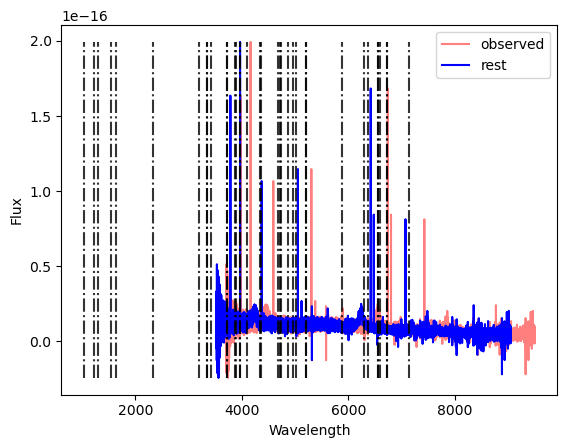

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104_Reff_spec.fits


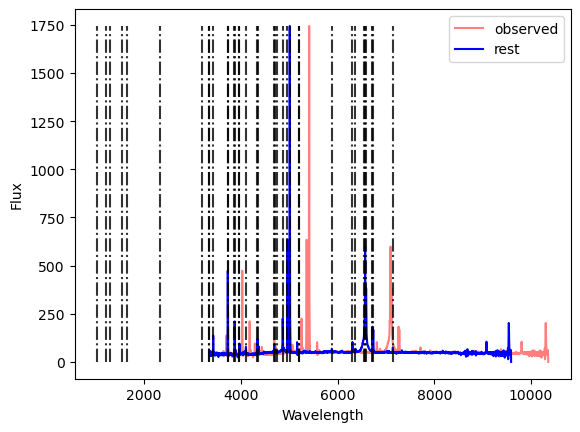

Has a redshift of  0.08000000000000002
SNR is  -1.559271710061084
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8553-1901-0.5Reff.fits


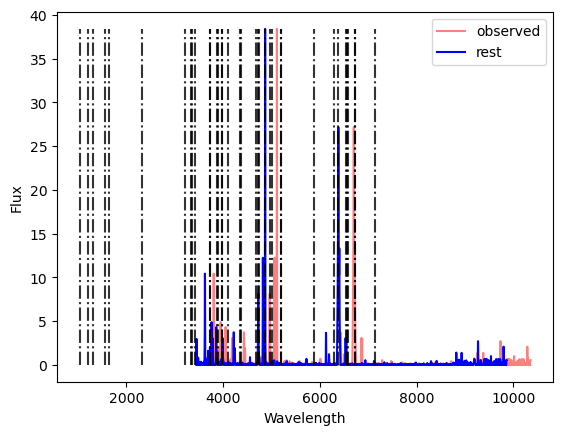

Has a redshift of  0.05
Closest peak index not found for line: O-III,0
UnboundLocalError
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8550-3704-0.5Reff.fits


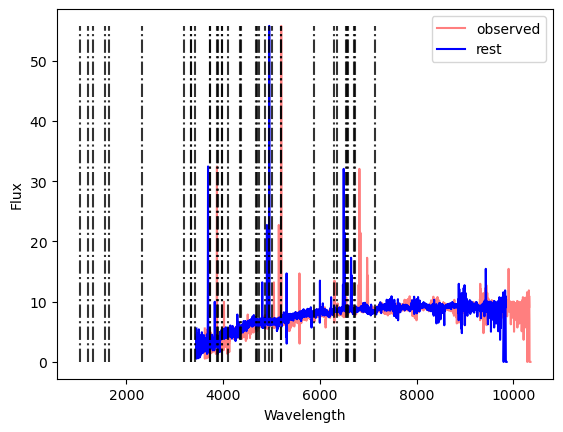

Has a redshift of  0.05
SNR is  2.491718870008413
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7815-6104-0.5Reff.fits


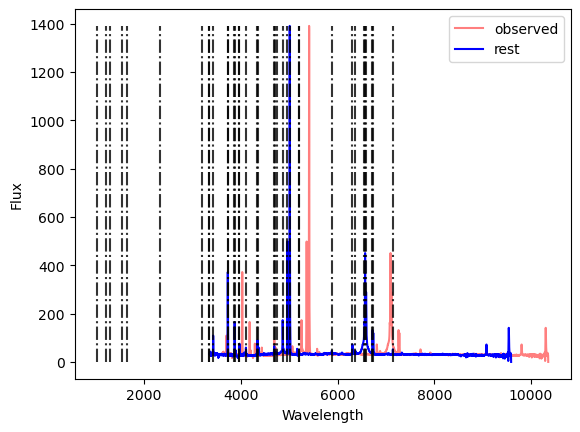

Has a redshift of  0.08000000000000002
SNR is  -1.2842317858009236
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9000-1901-0.5Reff.fits


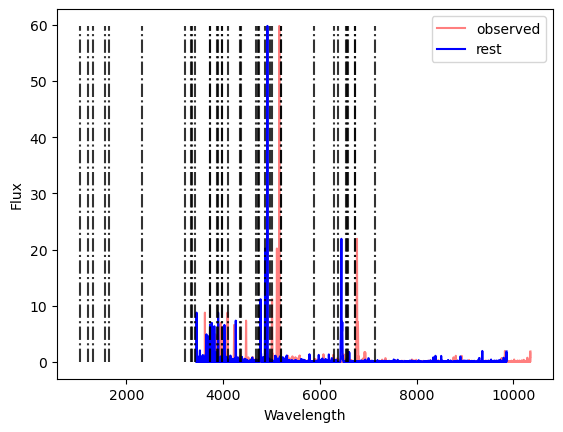

Has a redshift of  0.05
SNR is  8.821074510153439
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7958-9101_Reff_spec.fits


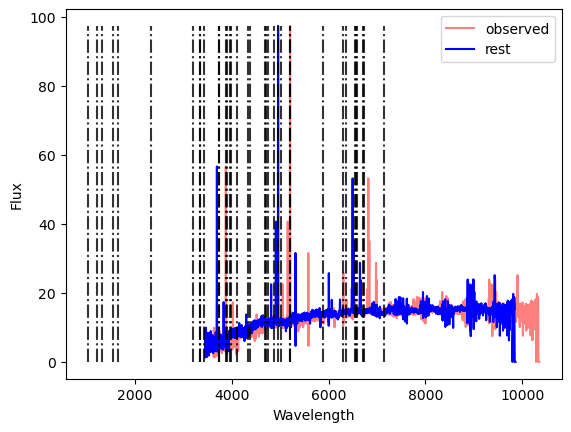

Has a redshift of  0.05
SNR is  1.4741603932950567
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7992-9102_Reff_spec.fits


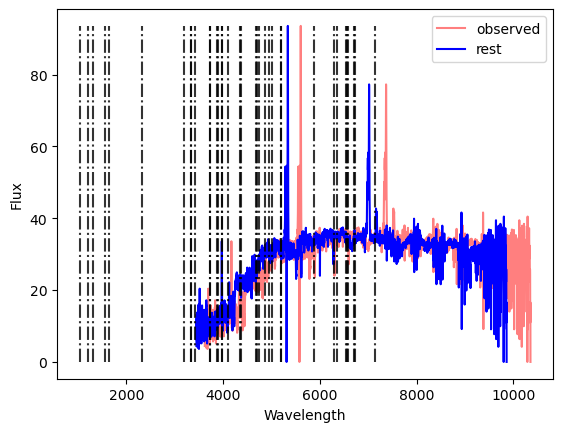

Has a redshift of  0.05
SNR is  4.07258788553025
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-9028-6102-0.5Reff.fits


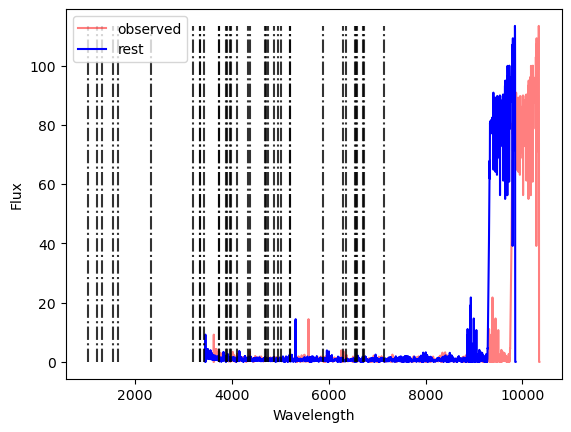

Has a redshift of  0.05
SNR is  8.755626506346902
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-7978-12705_Reff_spec.fits


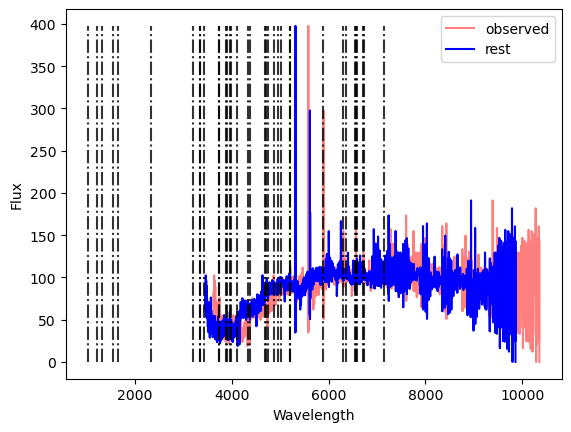

Has a redshift of  0.05
SNR is  39.17164842038863
/Users/aksitadeo/PycharmProjects/spelfig_aksita/input/manga-8550-3704-0.5Reff-DAP.fits


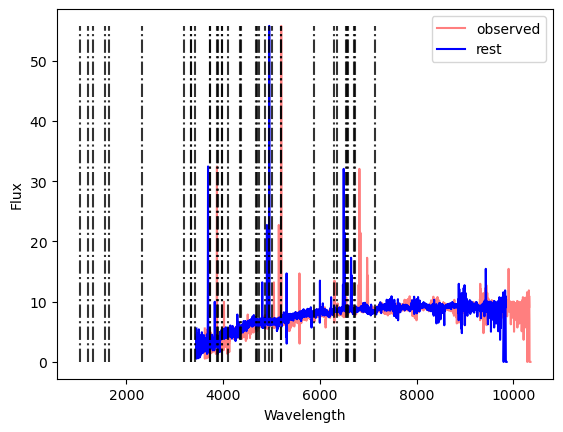

Has a redshift of  0.05
SNR is  2.491718870008413


In [87]:
import os

directory = '/Users/aksitadeo/PycharmProjects/spelfig_aksita/input'

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".fits"): # filename.startswith("manga") and
        print(os.path.join(directory, filename))
        full_dir = os.path.join(directory, filename)

        # id
        spec_dict['ID'].append(filename)                                        # to be edited by JL

        # spectra
        data = extract_astronomical_data(full_dir)
        spec_dict['SPECTRA'].append(data)

        redshift
        redshift = redshift_templ(data,Plot=True)
        print("Has a redshift of ", redshift)
        spec_dict['REDSHIFT'].append(redshift)

        # snr
        try:
          snr = extract_snr(data, redshift, line='O-III,0')
          spec_dict['SNR'].append(snr)
        except:
          print('UnboundLocalError')
          spec_dict['SNR'].append(0)

        continue
    else:
        continue

In [88]:
spec_dict

{'ID': ['PAQS_000439.86-271539.36_LJ1.fits',
  'magpi2304104201_aperture_1.25R50_ppxf.fits',
  'PAQS_013700.03-333858.58_LJ1.fits',
  'PAQS_011708.49-191258.11_LJ1.fits',
  'PAQS_000351.38-153220.14_LJ1.fits',
  'PAQS_000153.90-215901.05_LJ1.fits',
  'PAQS_021149.04-260810.71_LJ1.fits',
  'PAQS_002742.94-293946.14_LJ1.fits',
  'PAQS_014817.88-615640.60_LJ1.fits',
  'PAQS_023018.71-551419.94_LJ1.fits',
  'PAQS_005214.83-513256.07_LJ1.fits',
  'PAQS_003936.39-363904.01_LJ1.fits',
  'PAQS_030347.63-233455.49_LJ1.fits',
  'PAQS_022444.84-625501.78_LJ1.fits',
  'manga-7815-6104-0.5Reff-DAP.fits',
  'PAQS_012718.76-292642.57_LJ1.fits',
  'PAQS_023852.89-552941.58_LJ1.fits',
  'PAQS_002140.16-415827.99_LJ1.fits',
  'PAQS_024537.77-211635.19_LJ1.fits',
  'PAQS_000537.14-192913.35_LJ1.fits',
  'PAQS_000047.09-302857.50_LJ1.fits',
  'PAQS_022233.90-513102.95_LJ1.fits',
  'PAQS_024533.09-490220.28_LJ1.fits',
  'PAQS_021915.28-600523.07_LJ1.fits',
  'PAQS_014243.22-302233.55_LJ1.fits',
  'PAQS_002

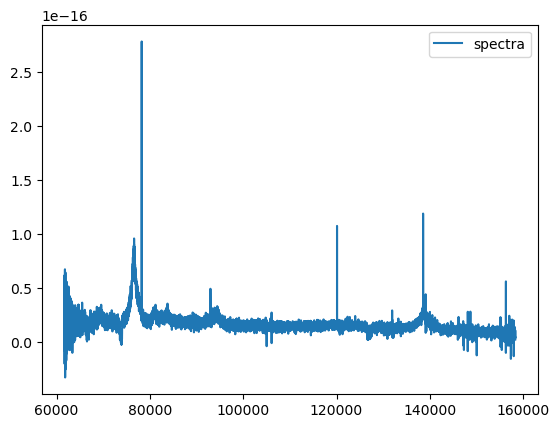

In [91]:
plt.plot(spec_dict['SPECTRA'][0].T[0]/(spec_dict['REDSHIFT'][0]), spec_dict['SPECTRA'][0].T[1], label = 'spectra');
# plt.plot(spec_dict['SPECTRA'][-2].T[0], spec_dict['SPECTRA'][-2].T[2]-100,label = 'errors');
plt.legend()

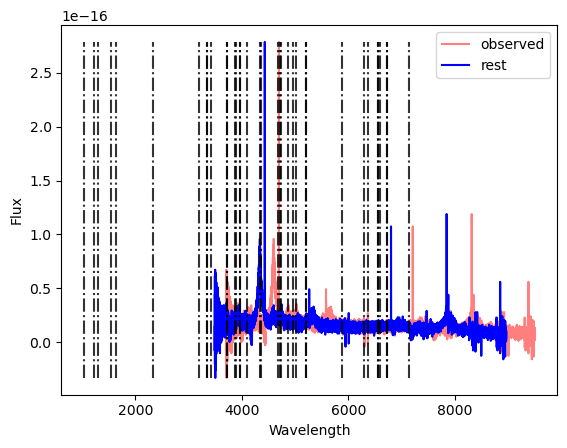

0.060000000000000005

In [83]:
redshift_templ(spec_dict['SPECTRA'][0],Plot=True)

In [ ]:
redshift_templ(spec_dict['SPECTRA'][0], Plot=True)

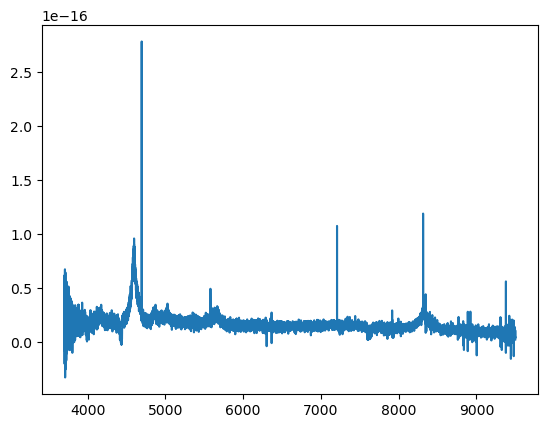

In [92]:
plt.plot(spec_dict['SPECTRA'][0].T[0],spec_dict['SPECTRA'][0].T[1])

# Further steps: Automatic algorithm of fitting.
Given a set of different AGN spectra, we must figure out a good set of automatic steps to:
* Start from a baseline model for all AGN. Produce a first fitting
* Add components in an automatic way to the emission profiles that require them (problem: they might be different distributions, and profiles in certain cases might be very broadened and extreme).
* Once we got this cycled solved, transform all of this into an automatic set of scripts, instead of notebook.
* Upload the resultant code to a GitHub.